# Автоматизация подбора цены исходя из эластичности спроса
подготовил: [Вова Сизов](mailto:vladimirsizov@yandex.ru)
<hr>

При работе с ценой на маркетплейсе я столкнулся с необходимостью подбора оптимальной цены.  
У нас есть датасет с продажами нового товара. Цена товара определялась не известным нам способом.  

Задача заключалась в том чтобы:
- сэкономить время не выполняя однотипные операции ежедневного пересчёта цены 
- научится подобрать оптимальную цену за минимальное время  

Появился вопрос сколько и каких данных нужно чтобы начать прогнозировать оптимальную цену?  
Спойлер: себестоимость, средняя цена товара в нише и минимум три дня количественных продаж.

### Вводные данные

Существует множество параметров по которым продавец определяет какую цену для клиента устанавливать?  
Здесь я не буду учитывать такие факторы как реклама или участие в акции, стоимость комиссий и прочее по отдельности, всё это можно вычислять по данным последних продаж и поместить в условную переменную - себестоимость товара.

Так как продажи это про прибыль мы оставим этот параметр, из суммы расходов и прибыли у нас образуется цена товара для потребителя.  

### Эластичность спроса

Это такой показатель который говорит нам о зависимости количества продаж от цены товара.  
Так как у товара есть себестоимость, значит чем дешевле продаётся товар тем меньше мы зарабатываем с единицы товара.  
При этом мы знаем что чем дешевле мы продаём товар тем больше едениц товара можно продать.  

Показателем эффективности продаж в первую очередь является прибыль - маржа помноженая на количество проданных товаров.  
Зная при каждой цене товара количество продаж мы можем посчитать прибыль при каждой цене суммируя покупки по каждой цене, а зная прибыль для каждой цены мы можем выбрать лучшую цену с точки зрения извлечения прибыли.  

При этом если мы получаем одинаковую прибыль при разном количестве продаж мы можем выбрать цену где мы больше продаём.


<hr>

Импортируем библиотеки с которыми будем работать

In [197]:
import pandas as pd
import numpy as np
import scipy
import random

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings(action='ignore')

Это датасет с данными фактических продаж.

In [198]:
bp = pd.read_excel('data.xlsx')
# добавим данных
bp['revenue'] = round(bp.revenue, 2)
bp['price'] = (bp.revenue / bp.orders).astype(int)
bp['profit'] = round(bp.revenue - (bp.orders * cost_price), 2)
bp

date  orders    revenue  price     profit
0  2023-04-01      16  127872.00   7992   79872.00
1  2023-04-02      14  111888.00   7992   69888.00
2  2023-04-03       9   71928.00   7992   44928.00
3  2023-04-04       5   43956.00   8791   28956.00
4  2023-04-05       7   53586.61   7655   32586.61
5  2023-04-06       5   39960.00   7992   24960.00
6  2023-04-07       3   23676.30   7892   14676.30
7  2023-04-08       1    7892.10   7892    4892.10
8  2023-04-09       3   23676.30   7892   14676.30
9  2023-04-10      15  118381.50   7892   73381.50
10 2023-04-11      15  118381.50   7892   73381.50
11 2023-04-12      11   86813.10   7892   53813.10
12 2023-04-13      13   98701.20   7592   59701.20
13 2023-04-14       5   37462.50   7492   22462.50
14 2023-04-15      13   97402.50   7492   58402.50
15 2023-04-16      11   81318.60   7392   48318.60
16 2023-04-17      11   81318.60   7392   48318.60
17 2023-04-18       8   51144.00   6393   27144.00
18 2023-04-19      14   89502.00   6393   47502.00
19 2023-04-20      28  167832.00   5994   83832.00
20 2023-04-21      21  121678.20   5794   58678.20
21 2023-04-22      20  115884.00   5794   55884.00
22 2023-04-23      15   86913.00   5794   41913.00
23 2023-04-24      17   98501.40   5794   47501.40
24 2023-04-25      30  179820.00   5994   89820.00
25 2023-04-26      27  153746.10   5694   72746.10
26 2023-04-27      29  156443.40   5394   69443.40
27 2023-04-28      25  132367.50   5294   57367.50
28 2023-04-29      31  176523.30   5694   83523.30
29 2023-04-30      34  210589.20   6193  108589.20

Нам известно что себестоимость товара равна 3000  
Определим её в переменную cost_price

In [199]:
# себестоимость товара
cost_price = 3000

Посчитаем зависимость количества заказов от цены

In [200]:
# посчитаем зависимость количества заказов от цены
gen_data = bp.groupby('price').agg({'orders': 'mean'}).reset_index()
gen_data = gen_data[['orders', 'price']]
gen_data

orders  price
0    25.00   5294
1    29.00   5394
2    29.00   5694
3    18.25   5794
4    29.00   5994
5    34.00   6193
6    11.00   6393
7    11.00   7392
8     9.00   7492
9    13.00   7592
10    7.00   7655
11    8.00   7892
12   11.00   7992
13    5.00   8791

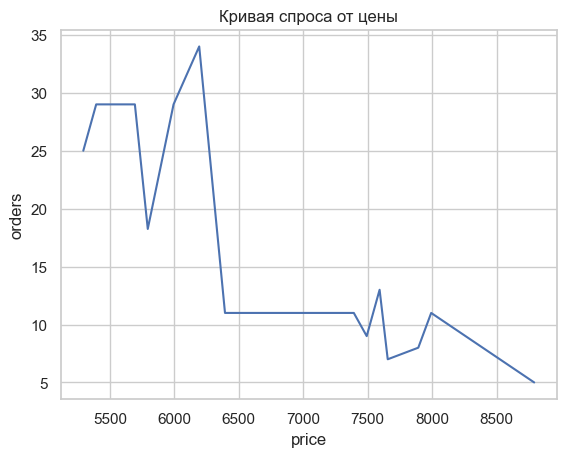

In [201]:
sns.lineplot(gen_data, x='price', y='orders')
plt.title('Кривая спроса от цены')
plt.show();

<hr>

Предположим что мы только только зашли на рынок с нашим товаром, и пока ещё не знаем кривой спроса на этот товар.  

Мы уже определили цену ниже которой мы не станем опускатся (cost_price - себестоимость)  

Еще мы какбы посчитали среднюю цену продаж аналогичного товара в товарной нише и поместили в переменную mean_price  

In [202]:
# определяем среднюю цену товара
gen_data['revenue'] = gen_data.price * gen_data.orders
mean_price = int(gen_data.revenue.sum() / gen_data.orders.sum())
gen_data = gen_data.drop(columns='revenue')
mean_price

6312

На самом деле точность mean_price не сильно важна, она может отличатся в 1.5-2 раза, в этом случае время подбора увеличится на несколько дней.
Давайте продемонстрируем это переопределив в переменную normal_price

In [203]:
normal_price = mean_price * 1.5

Функция get_elast  

Возвращает:
- оптимальную цену исходя из прибыли и объёма продаж и размер прибыли
- таблицу с сглаженными данными (необходимо при недостатке данных или сильной зашумленности)
- Графики 'Кривая спроса от цены', 'Кривая прибыли от цены'

Принимает:
- датафрейм с колонками ['orders', 'price']
- себестоимость товарной единицы
- указывая параметр smoth > 0 мы определяем степень сглаживаемости кривой спроса, это даёт значительный эффект при малых объёмах данных (тоесть почти всегда)
- chart определяет хотим ли мы визуализировать данные в графиках
- return_data сообщает о том что мы хотим получить не оптимальную цену и размер прибыли а датафрейм со всеми данными

Функция получает данные за определённый период продаж и группирует их по одинаковой цене.  
Для того чтобы опредилить оптимальную цену - уникальных цен должно быть не менее трёх, в идеале пяти.  
При этом количество продаж должно быть более чем количество уникальных цен.  

Затем считается прибыль для каждой цены и находится цена с максимальной прибылью.
При наличии нескольких мод по прибыли цена выбирается с максимальным количеством продаж.

В конце рисуются графики.

Если мы используем сглаживание то из набора аггрегированных данных определяется диапазон из 100 различных цен между минимальной и максимальной.  
Затем определяется показатель значения количества заказов методом интерполяции, и применяем сглаживание.  
В этом случае расчёт оптимальной цены идёт не из исходных данных а сглаженых.

In [204]:
def get_elast(df, cost_price, smoth=0, chart=True, show_data=True, return_data=False):
    '''получение кривой спроса от прибыли и цены, а также оптимальной цены с приоритетом максимальной прибыли и количества продаж'''
    # Названия колонок входных данных должны быть ['orders', 'price']
    columns = df.columns.tolist()
    if columns == ['orders', 'price']:
        df = df.groupby('price').agg({'orders': sum}).reset_index()
        
        # Уникальных цен в колонке 'price' должнобыть больше 2, а число заказов должно быть больше числа уникальных цен.
        if (len(df) > 2) & (df.orders.sum() > (len(df))):
            df_copy = df.copy()
            if smoth > 0:
                # получим исходные значения
                # увеличим количество данных о ценах в 2 раза
                new_price = np.linspace(df.price.min(), df.price.max(), 100)
                # сделаем линейную интерполяцию для orders
                orders_interp = scipy.interpolate.interp1d(df.price, df.orders)
                new_orders = [orders_interp(i).tolist() for i in new_price]
                # сгладим значения
                Y = np.polyval(np.polyfit(new_price, new_orders, smoth), new_price)
                df = pd.DataFrame({'price': new_price, 'orders': Y})
            
            # считаем прибыль
            df['profit'] = (df.price - cost_price) * df.orders
            
            # визуализируем данные
            if show_data:
                display(df)

            # найдём максимальное значение прибыли
            max_profit = df.profit.max()
            # определяем цену для максимальной прибыли
            max_profit_price = df[df.profit == max_profit].price
            # при одинаковой прибыли выбираем ту цену где больше продаж
            if len(max_profit_price)> 1:
                max_profit_orders = df[df.profit == max_profit].orders.max()
                max_profit_price = df[(df.profit == max_profit) & (df.orders == max_profit_orders)].price.values[0]
            else:
                max_profit_price = df[df.profit == max_profit].price.values[0]
            
            # нарисуем графики
            if chart:
                # нарисуем графики
                sns.lineplot(df_copy, x='price', y='orders')
                sns.lineplot(df, x='price', y='orders')
                plt.legend(['исходные данные', 'усреднённые данные']);
                plt.title('Кривая спроса от цены')
                plt.show();
                sns.lineplot(df, x='price', y='profit')
                plt.scatter(max_profit_price, max_profit, color='red')
                plt.title('Кривая прибыли от цены')
                plt.show();
            
            if return_data:
                return df
            else:
                return [max_profit_price, max_profit]
 
        else:
            print("Уникальных цен в колонке 'price' должнобыть больше 2", 
                  "\nЧисло заказов должно быть больше числа уникальных цен.")
    else:
        print("Названия колонок входных данных должны быть ['orders', 'price']")

Преобразуе данные gen_data из 19 в 100 строк, и смягчим кривую спроса, для более точных расчётов.

Ниже находится датафрем со обработанными данными, а также два графика:  
- кривая спроса от цены (синий - исходные данные, оранжевый - сглаженные)
- кривая прибыли от цены (красная точка - значение максимальной прибыли) 

Запомним что лучшая цена 5929.82

В самом низу список [оптимальная_цена, размер_прибыли_при_этой цене]

price     orders        profit
0   5294.000000  28.964547  66444.670794
1   5329.323232  27.762342  64667.467567
2   5364.646465  26.989371  63820.321764
3   5399.969697  26.558075  63738.576183
4   5435.292929  26.391553  64271.162170
..          ...        ...           ...
95  8649.707071   6.775357  38278.779666
96  8685.030303   6.289297  35754.846593
97  8720.353535   5.647190  32303.920772
98  8755.676768   4.813074  27702.500083
99  8791.000000   3.746074  21693.516138

[100 rows x 3 columns]

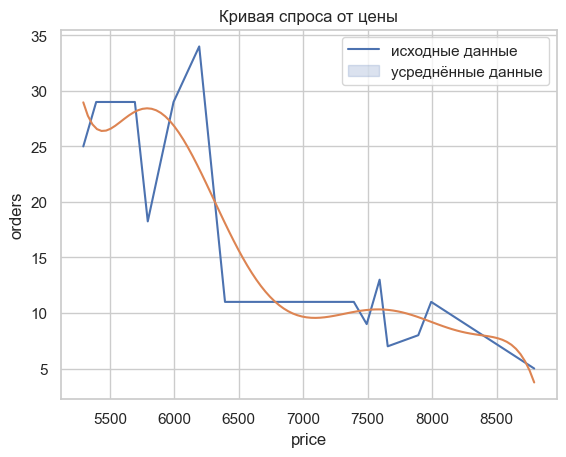

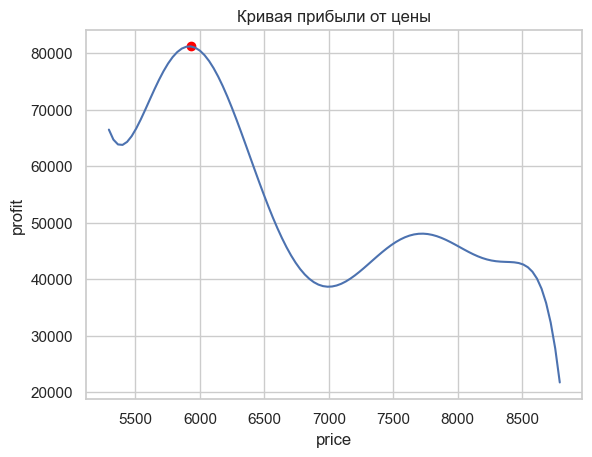

[5929.818181818182, 81162.51407673126]

In [205]:
get_elast(gen_data, cost_price, smoth=8)

<hr>

Создадим датафрейм с элстичностью спроса на наш товар. Отсюда мы будем брать данные о результатах наших будущих продаж.  
Помним что на самом деле мы как бы пока ещё не знаем этих данных. 

In [206]:
# датафрейм эластичности спроса 
df = get_elast(gen_data, cost_price, smoth=8, chart=False, show_data=False, return_data=True)
df#.head()

price     orders        profit
0   5294.000000  28.964547  66444.670794
1   5329.323232  27.762342  64667.467567
2   5364.646465  26.989371  63820.321764
3   5399.969697  26.558075  63738.576183
4   5435.292929  26.391553  64271.162170
..          ...        ...           ...
95  8649.707071   6.775357  38278.779666
96  8685.030303   6.289297  35754.846593
97  8720.353535   5.647190  32303.920772
98  8755.676768   4.813074  27702.500083
99  8791.000000   3.746074  21693.516138

[100 rows x 3 columns]

Чтобы жизнь нам не казалась одной малиной при запросе к этим данным мы также будем вносить шум относительно получаемого размера продаж к цене, так как продажи день на день не приходятся одинаковыми (подробнее в описании к функции get_count_orders)

Наш эксперимент будет длится 30 дней

In [207]:
# дата начала эксперимента
date_start = pd.to_datetime('2023-04-01')

# дней эксперимента
days = 30

Так как первые дни у нас будет недостаточно данных для кривой спроса мы будем каждый день работать с новой ценой из списка list_prices до тех пор пока не наберём необходимое количество. 

Здесь у нас три цены:
- средняя цена товара в нише normal_price
- цена товара ниже которой мы не продаём cost_price (себестоимость)
- среднее значение предыдущих двух цен

Условие при которых считаем что данных достаточно чтобы считать цену через эластичность: 
- разных цен должно быть больше двух
- количество купленых товаров больше чем разных цен

last_ind_list_prices нам понадобится при работе с функцией get_primary_price

In [208]:
# последняя использованная цена из списка цен
last_ind_list_prices = 0

# создаём список цен для первичного тестирования эластичности
list_prices = [normal_price, (normal_price + cost_price) / 2, cost_price]

list_prices

[9468.0, 6234.0, 3000]

Ниже представлены функции к которым будет обращатся наш алгоритм:
- get_last_orders возвращает датафрейм данных о последних продажах за указанное в last_days количестве дней (по умолчанию 7)
- get_premission_elasticity сообщает достаточно ли у нас собрано данных для использования функции прогноза эластичности спроса
- get_count_orders возвращает количество заказов при определённой цене из исходных данных, причем получаемые результаты будут с шумом +/- 20% от данных из таблицы df
- get_primary_price возврщает цену при первичном тестировании цен

In [209]:
def get_last_orders(df, last_days=7):
    '''получаем заказы за последние (указанное количество) дней'''
    try:
        return df[(df.date > df.date.max() - pd.Timedelta(days=last_days)) & (df.date <= df.date.max())]
    except:
        return df

In [210]:
def get_premission_elasticity(df):
    '''получить разрешение построить кривую спроса'''
    data = df.groupby('price').agg({'orders': 'mean'}).reset_index()
    # уникальных цен в колонке price должнобыть больше 2, а число заказов в orders должно быть больше числа уникальных цен.
    if (len(data) > 2) & (data.orders.sum() > len(data)):
        return True
    else:
        return False

In [211]:
def get_count_orders(df, price):
    '''возвращает количество заказов из исходных данных'''
    for i in range(len(df)):
        # проверяем есть ли такая цена в данных, иначе берём предельные
        if price < df.price.min():
            return df.orders.max()
        elif price > df.price.max():
            return df.orders.min()
        else:
            # если текущая цена меньше искомой цены
            if df.loc[i].price < price:
                continue
            # если текущая цена больше
            else:
                # внесём немного случайности в количество заказов
                orders = int(random.uniform(df.loc[i].orders*0.8, df.loc[i].orders*1.2))
                orders = df.loc[i].orders
                return orders

In [212]:
def get_primary_price(list_prices, last_ind_list_prices):
    '''получаем цену из списка цен для первичного тестирования эластичности'''
    price = list_prices[last_ind_list_prices]
    if last_ind_list_prices < (len(list_prices) - 1):
        last_ind_list_prices += 1
    else:
        last_ind_list_prices = 0
    return [price, last_ind_list_prices]

Непосредственно здесь мы будем имитировать продажи и подбор оптимальной цены на двух кадрах данных за предыдущие 7 и 14 дней, и брать их среднее арифметическое.  

При каждой итерации мы будем показывать тот кадр данных с которыми работаем в этот день, а также построим графики кривых спроса и прибыли.  

Порядок:
- получаем данные предыдущего периода
- выясняем достаточно ли данных для рассчёта оптимальной цены.
- считаем оптимальную цену если данных достаточно,  
если данных не достаточно берём цену из списка list_prices
- рисуем графики
- записываем данные текущего дня в data

Внимание!  
Сейчас будет много данных, поехали:

сегодня: 2023-04-01 
данные предыдущего периода:


Empty DataFrame
Columns: [date, orders, price, profit, elasticity]
Index: []

данных для расчёта оптимальной цены НЕ достаточно

--------------------------

сегодня: 2023-04-02 
данные предыдущего периода:


date  orders   price    profit  elasticity
0 2023-04-01       3  9468.0  24229.61       False

данных для расчёта оптимальной цены НЕ достаточно

--------------------------

сегодня: 2023-04-03 
данные предыдущего периода:


date  orders   price    profit  elasticity
0 2023-04-01       3  9468.0  24229.61       False
1 2023-04-02      21  6234.0  70038.11       False

данных для расчёта оптимальной цены НЕ достаточно

--------------------------

сегодня: 2023-04-04 
данные предыдущего периода:


date  orders   price    profit  elasticity
0 2023-04-01       3  9468.0  24229.61       False
1 2023-04-02      21  6234.0  70038.11       False
2 2023-04-03      28  3000.0      0.00       False

считаем оптимальную цену 7 дней


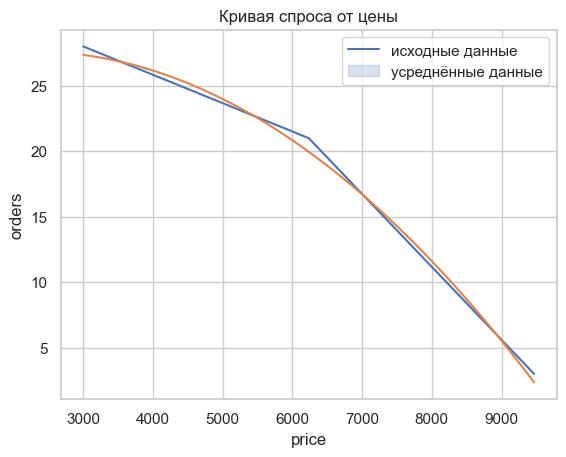

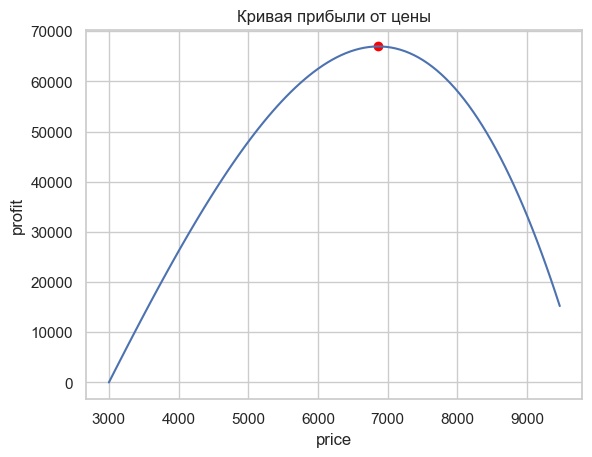

считаем оптимальную цену 14 дней


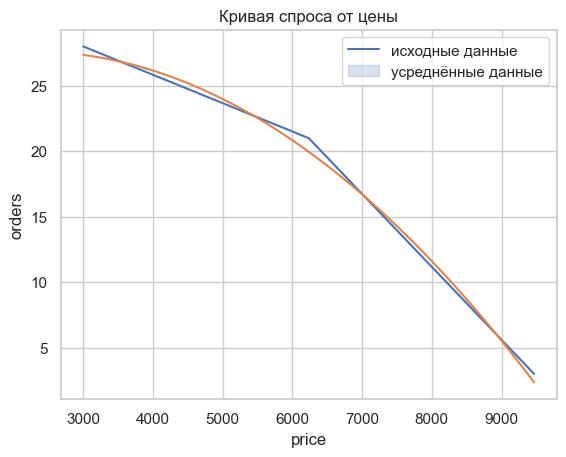

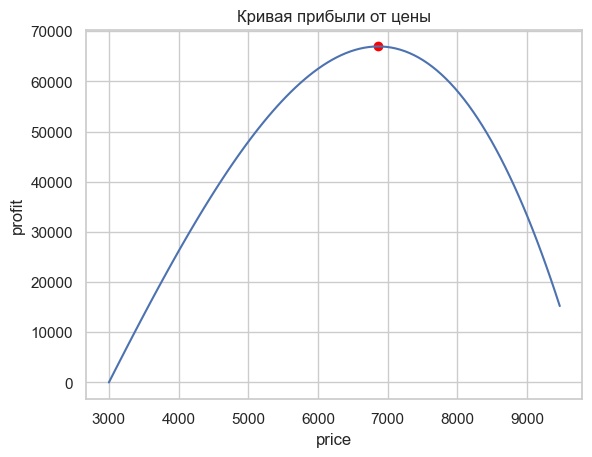


--------------------------

сегодня: 2023-04-05 
данные предыдущего периода:


date  orders    price    profit  elasticity
0 2023-04-01       3  9468.00  24229.61       False
1 2023-04-02      21  6234.00  70038.11       False
2 2023-04-03      28  3000.00      0.00       False
3 2023-04-04      10  6860.02  39201.21        True

считаем оптимальную цену 7 дней


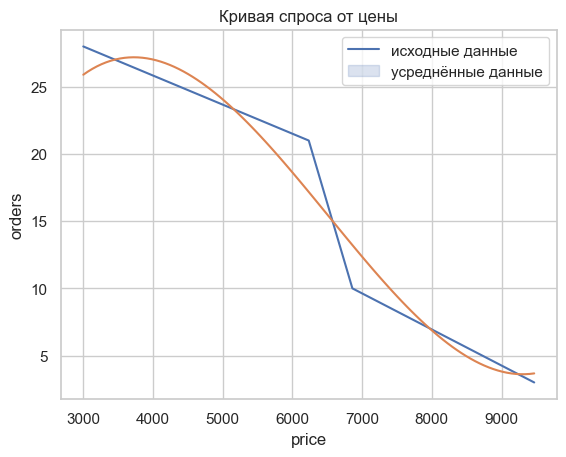

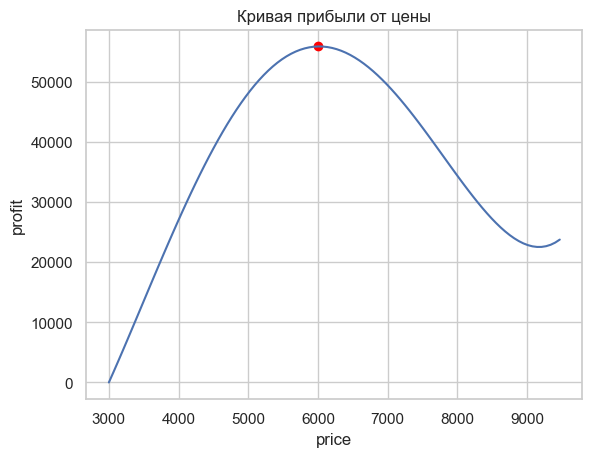

считаем оптимальную цену 14 дней


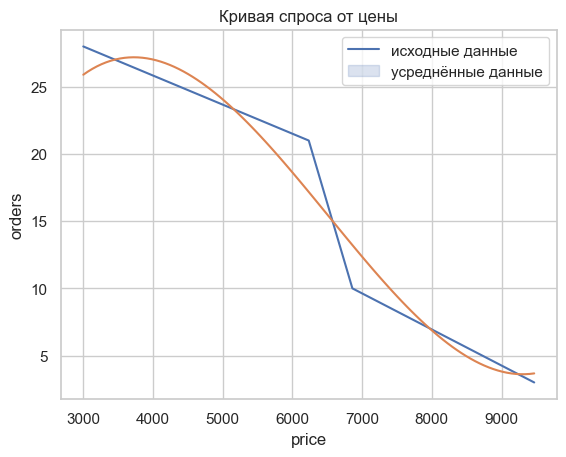

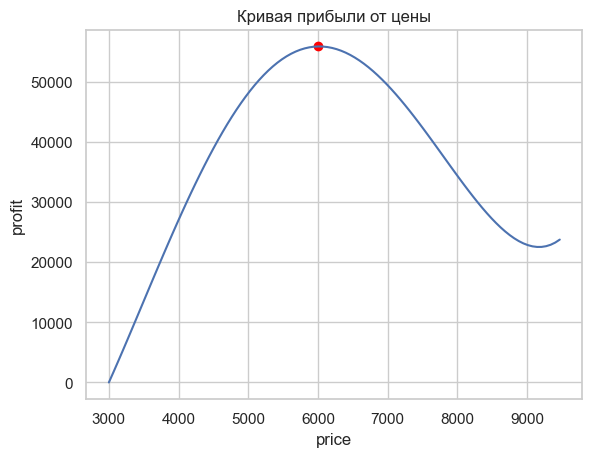


--------------------------

сегодня: 2023-04-06 
данные предыдущего периода:


date  orders    price    profit  elasticity
0 2023-04-01       3  9468.00  24229.61       False
1 2023-04-02      21  6234.00  70038.11       False
2 2023-04-03      28  3000.00      0.00       False
3 2023-04-04      10  6860.02  39201.21        True
4 2023-04-05      27  5945.78  80397.58        True

считаем оптимальную цену 7 дней


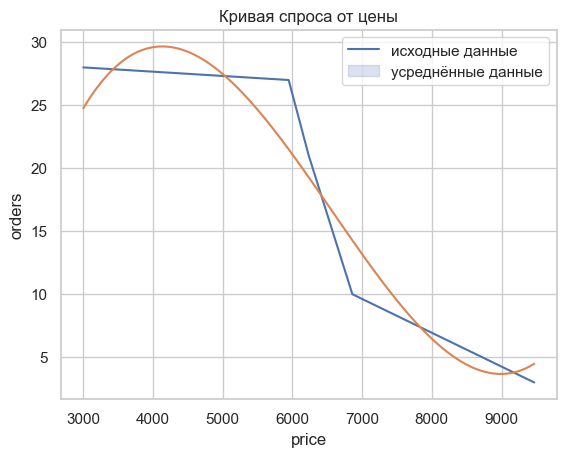

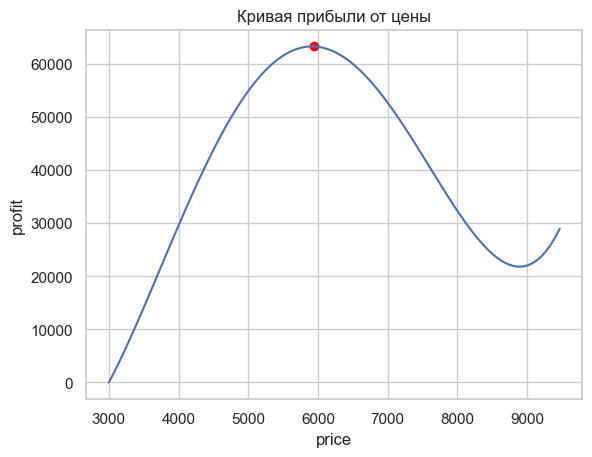

считаем оптимальную цену 14 дней


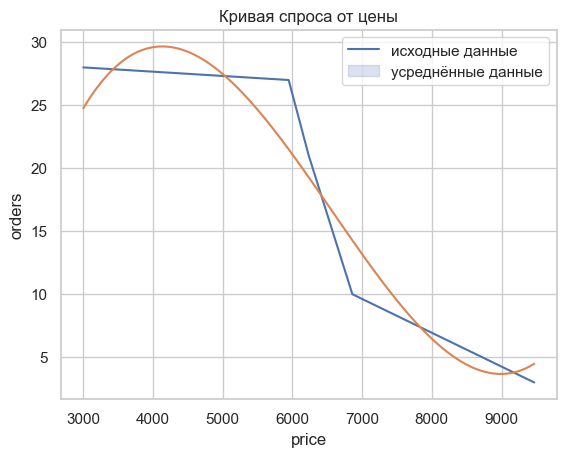

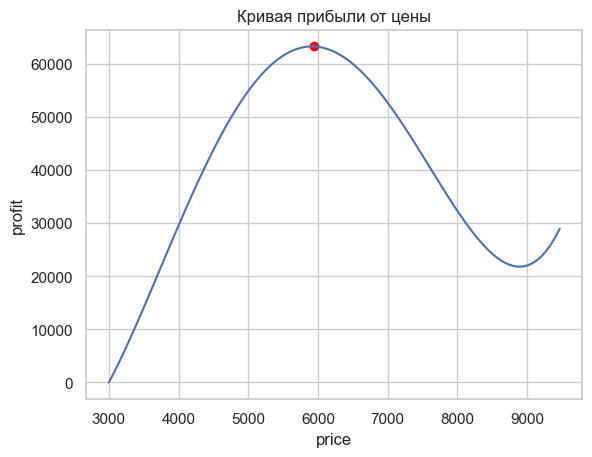


--------------------------

сегодня: 2023-04-07 
данные предыдущего периода:


date  orders    price    profit  elasticity
0 2023-04-01       3  9468.00  24229.61       False
1 2023-04-02      21  6234.00  70038.11       False
2 2023-04-03      28  3000.00      0.00       False
3 2023-04-04      10  6860.02  39201.21        True
4 2023-04-05      27  5945.78  80397.58        True
5 2023-04-06      26  5996.99  80317.00        True

считаем оптимальную цену 7 дней


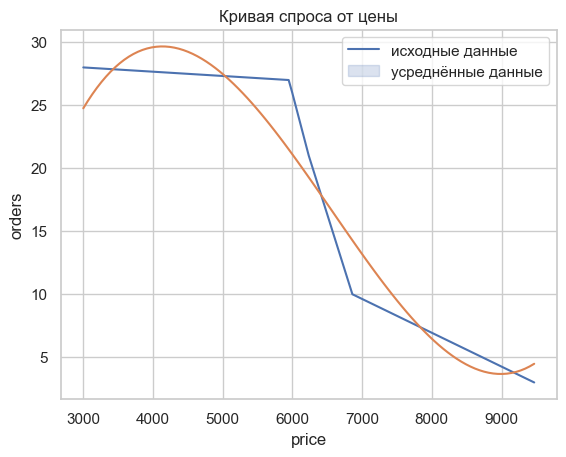

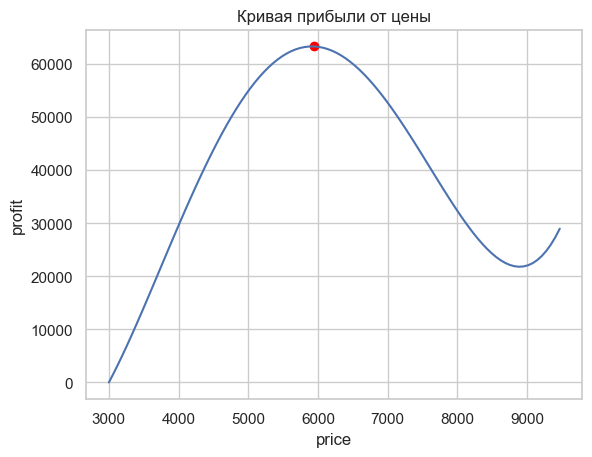

считаем оптимальную цену 14 дней


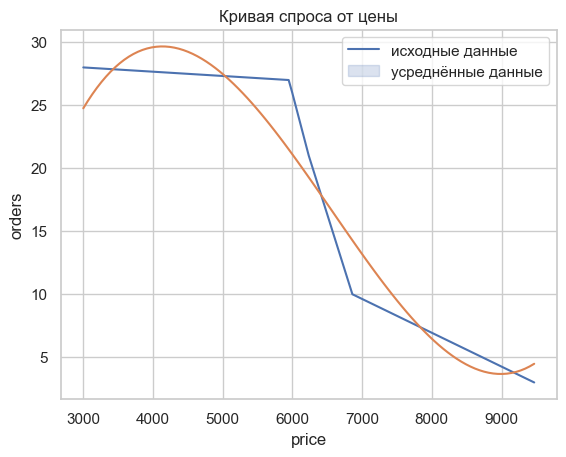

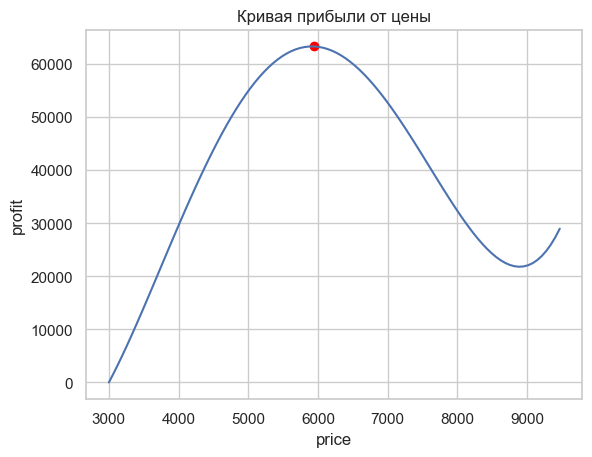


--------------------------

сегодня: 2023-04-08 
данные предыдущего периода:


date  orders    price    profit  elasticity
0 2023-04-01       3  9468.00  24229.61       False
1 2023-04-02      21  6234.00  70038.11       False
2 2023-04-03      28  3000.00      0.00       False
3 2023-04-04      10  6860.02  39201.21        True
4 2023-04-05      27  5945.78  80397.58        True
5 2023-04-06      26  5996.99  80317.00        True
6 2023-04-07      25  6048.12  77999.96        True

считаем оптимальную цену 7 дней


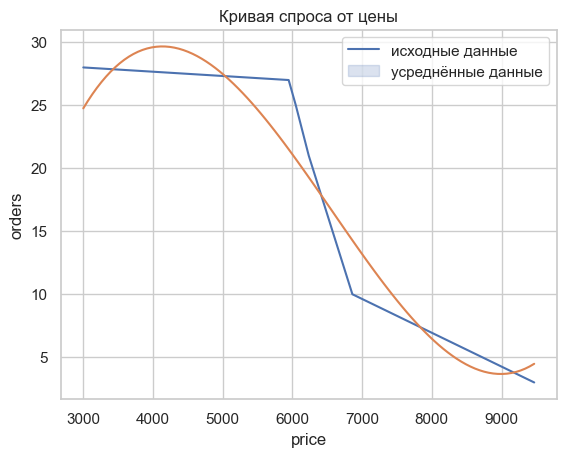

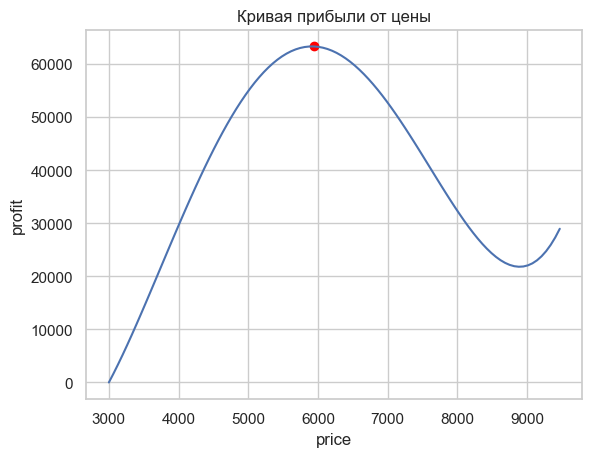

считаем оптимальную цену 14 дней


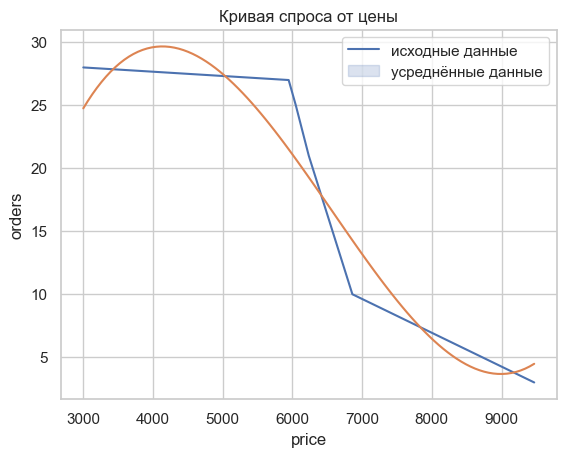

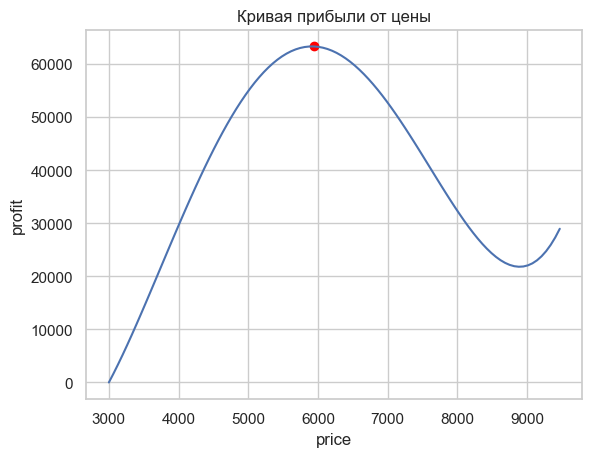


--------------------------

сегодня: 2023-04-09 
данные предыдущего периода:


date  orders    price    profit  elasticity
1 2023-04-02      21  6234.00  70038.11       False
2 2023-04-03      28  3000.00      0.00       False
3 2023-04-04      10  6860.02  39201.21        True
4 2023-04-05      27  5945.78  80397.58        True
5 2023-04-06      26  5996.99  80317.00        True
6 2023-04-07      25  6048.12  77999.96        True
7 2023-04-08      27  5925.52  81043.35        True

считаем оптимальную цену 7 дней


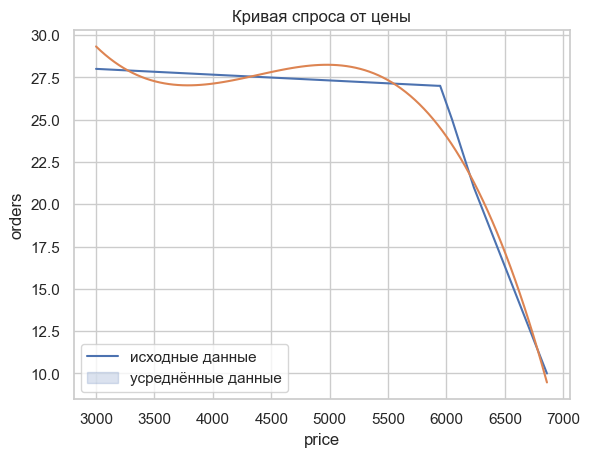

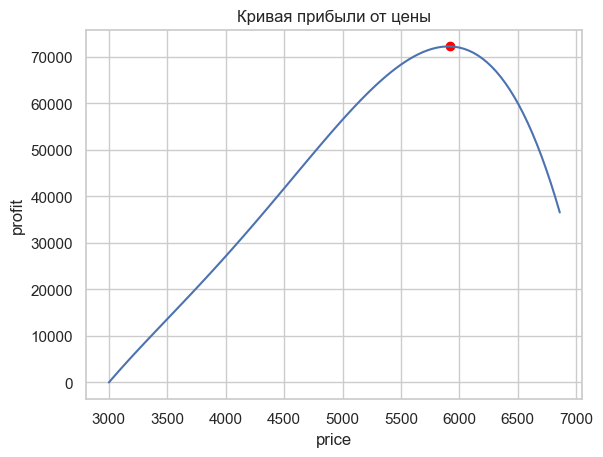

считаем оптимальную цену 14 дней


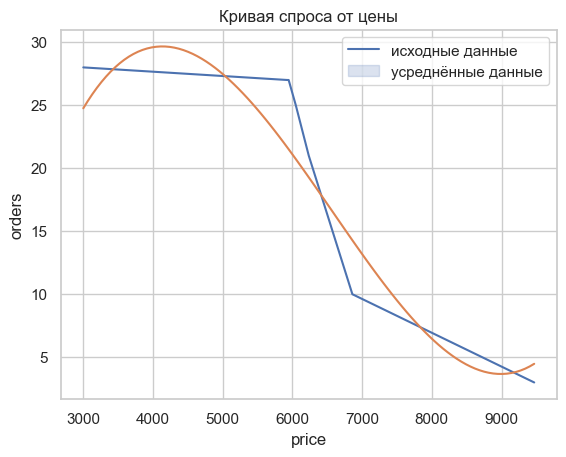

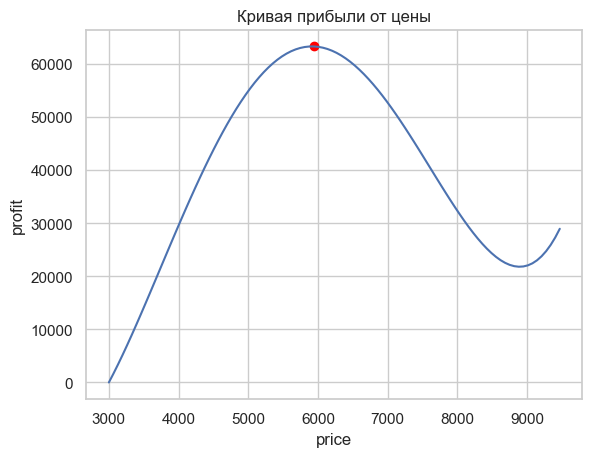


--------------------------

сегодня: 2023-04-10 
данные предыдущего периода:


date  orders    price    profit  elasticity
2 2023-04-03      28  3000.00      0.00       False
3 2023-04-04      10  6860.02  39201.21        True
4 2023-04-05      27  5945.78  80397.58        True
5 2023-04-06      26  5996.99  80317.00        True
6 2023-04-07      25  6048.12  77999.96        True
7 2023-04-08      27  5925.52  81043.35        True
8 2023-04-09      27  5946.57  80419.14        True

считаем оптимальную цену 7 дней


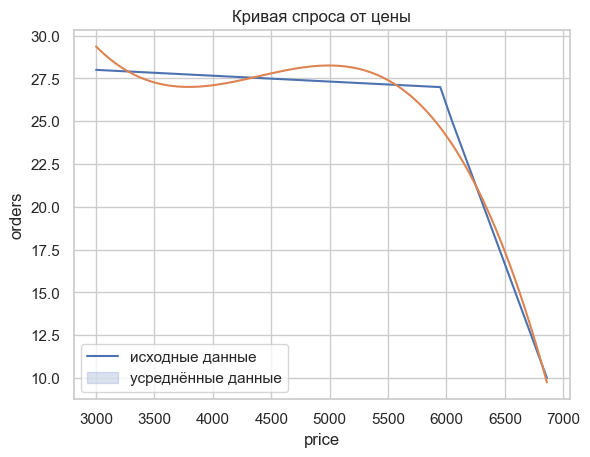

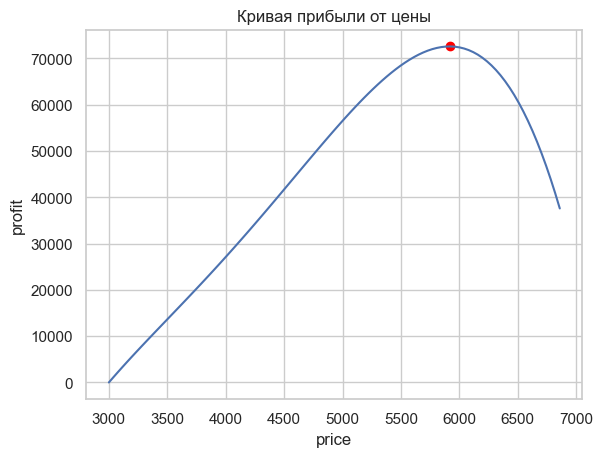

считаем оптимальную цену 14 дней


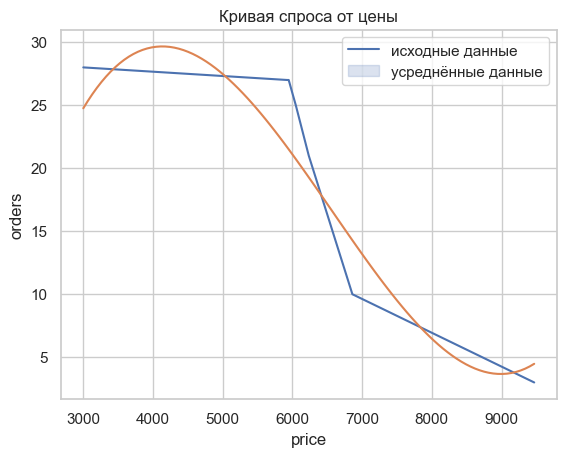

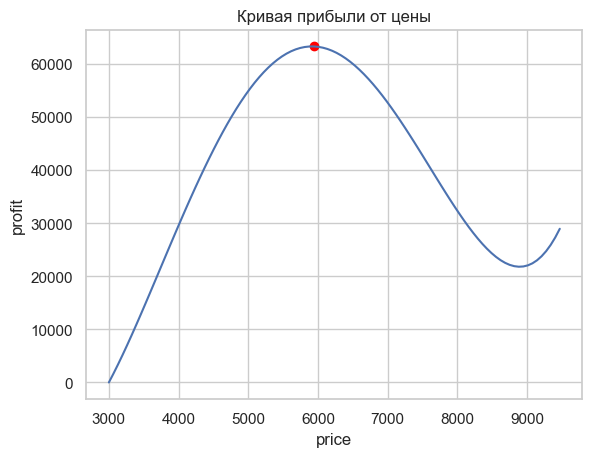


--------------------------

сегодня: 2023-04-11 
данные предыдущего периода:


date  orders    price    profit  elasticity
3 2023-04-04      10  6860.02  39201.21        True
4 2023-04-05      27  5945.78  80397.58        True
5 2023-04-06      26  5996.99  80317.00        True
6 2023-04-07      25  6048.12  77999.96        True
7 2023-04-08      27  5925.52  81043.35        True
8 2023-04-09      27  5946.57  80419.14        True
9 2023-04-10      27  5940.27  80247.31        True

считаем оптимальную цену 7 дней


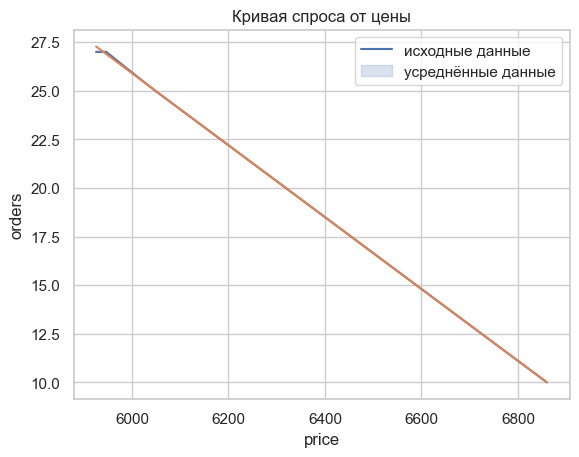

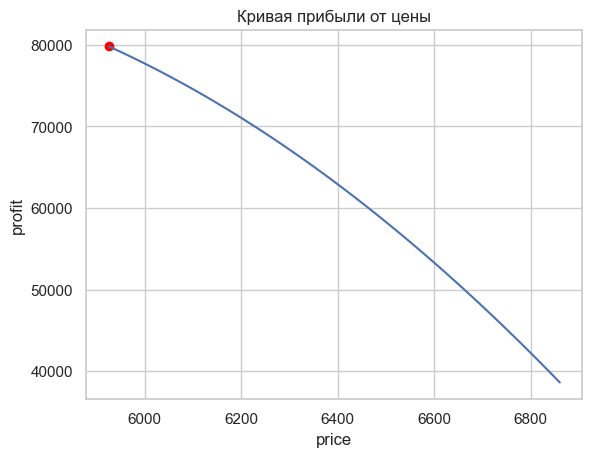

считаем оптимальную цену 14 дней


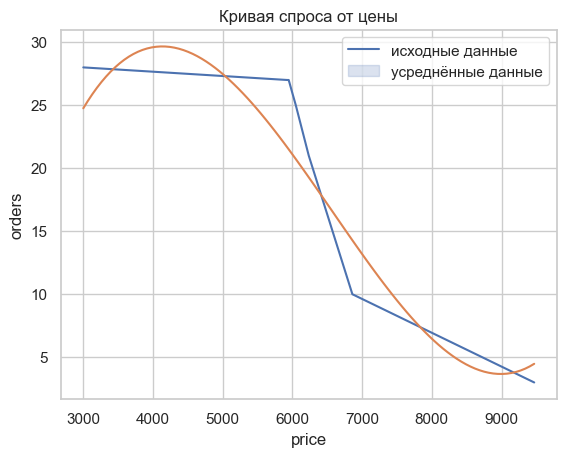

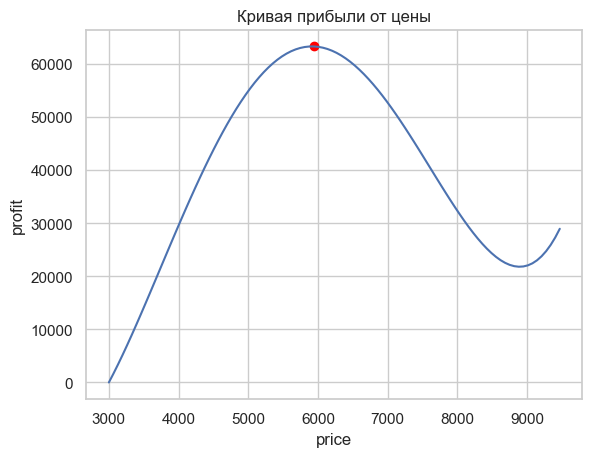


--------------------------

сегодня: 2023-04-12 
данные предыдущего периода:


date  orders    price    profit  elasticity
4  2023-04-05      27  5945.78  80397.58        True
5  2023-04-06      26  5996.99  80317.00        True
6  2023-04-07      25  6048.12  77999.96        True
7  2023-04-08      27  5925.52  81043.35        True
8  2023-04-09      27  5946.57  80419.14        True
9  2023-04-10      27  5940.27  80247.31        True
10 2023-04-11      28  5859.62  80136.20        True

считаем оптимальную цену 7 дней


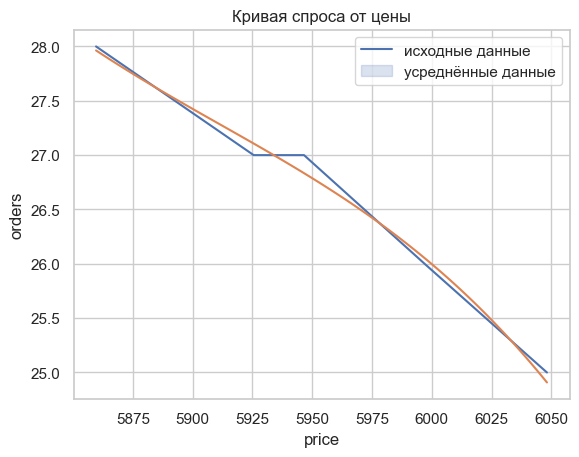

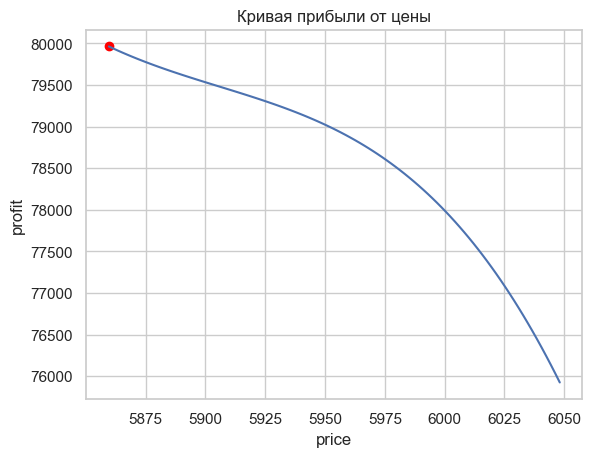

считаем оптимальную цену 14 дней


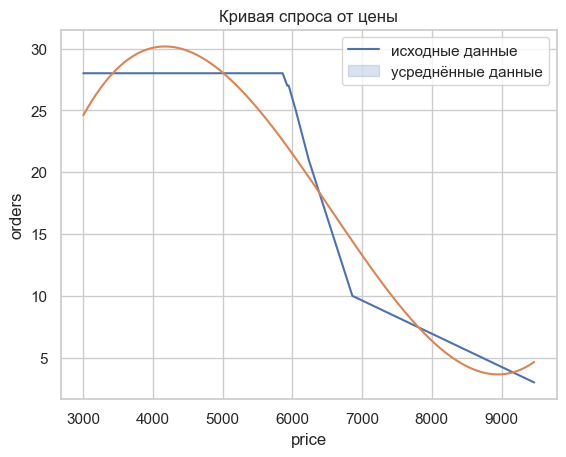

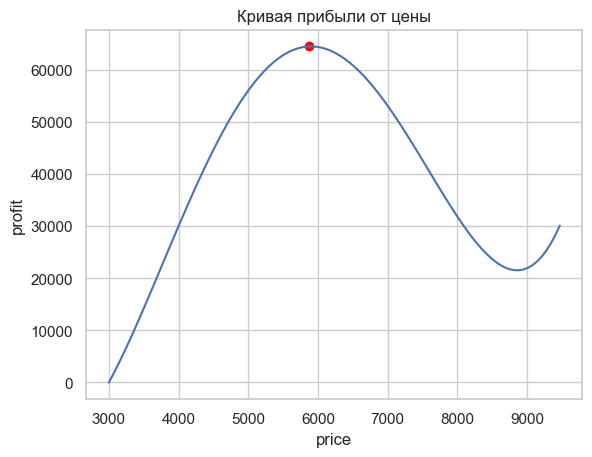


--------------------------

сегодня: 2023-04-13 
данные предыдущего периода:


date  orders    price    profit  elasticity
5  2023-04-06      26  5996.99  80317.00        True
6  2023-04-07      25  6048.12  77999.96        True
7  2023-04-08      27  5925.52  81043.35        True
8  2023-04-09      27  5946.57  80419.14        True
9  2023-04-10      27  5940.27  80247.31        True
10 2023-04-11      28  5859.62  80136.20        True
11 2023-04-12      28  5796.30  79380.89        True

считаем оптимальную цену 7 дней


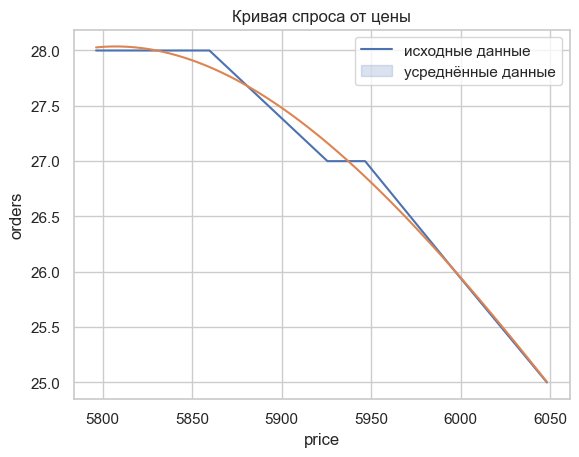

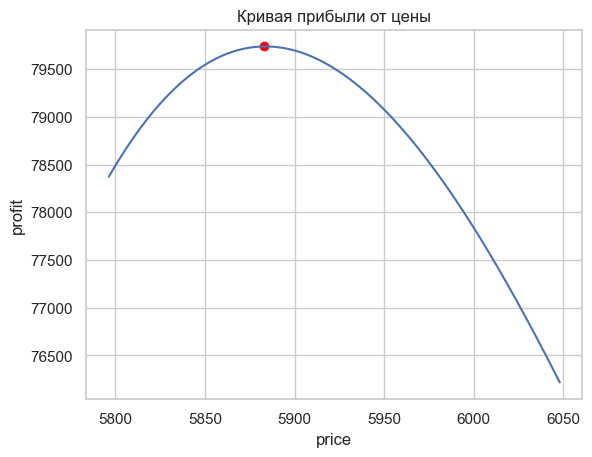

считаем оптимальную цену 14 дней


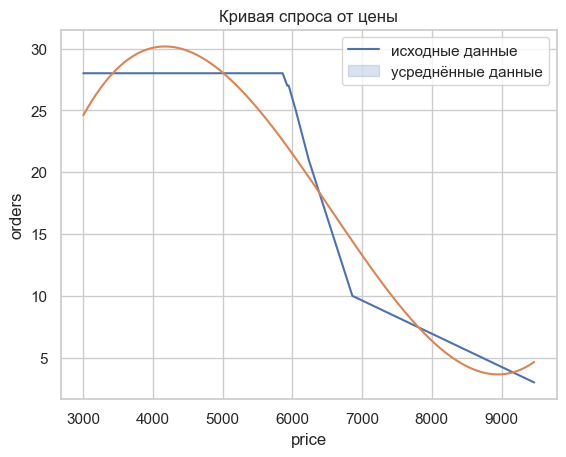

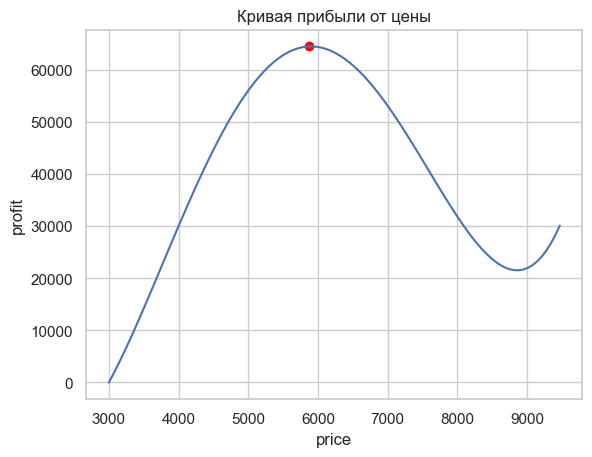


--------------------------

сегодня: 2023-04-14 
данные предыдущего периода:


date  orders    price    profit  elasticity
6  2023-04-07      25  6048.12  77999.96        True
7  2023-04-08      27  5925.52  81043.35        True
8  2023-04-09      27  5946.57  80419.14        True
9  2023-04-10      27  5940.27  80247.31        True
10 2023-04-11      28  5859.62  80136.20        True
11 2023-04-12      28  5796.30  79380.89        True
12 2023-04-13      28  5800.87  79510.65        True

считаем оптимальную цену 7 дней


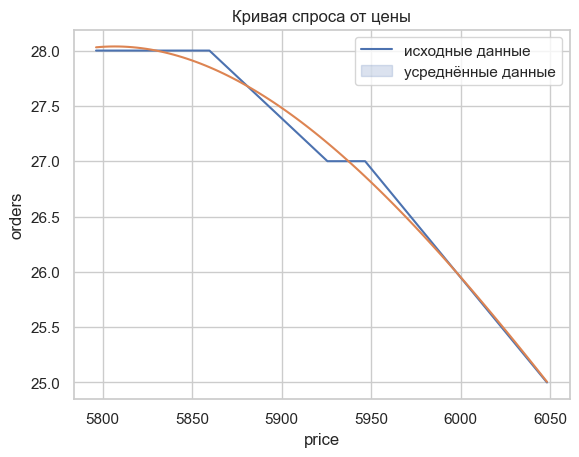

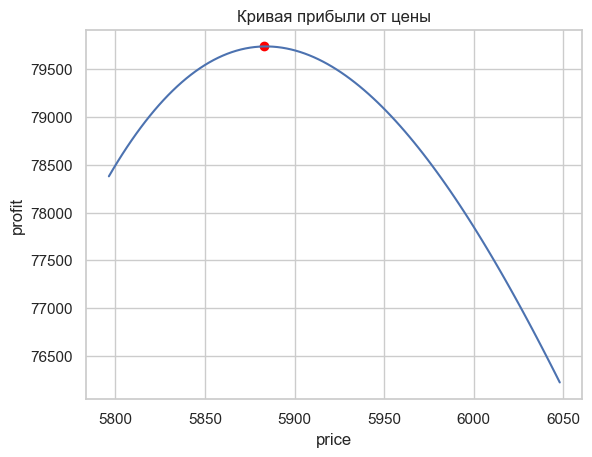

считаем оптимальную цену 14 дней


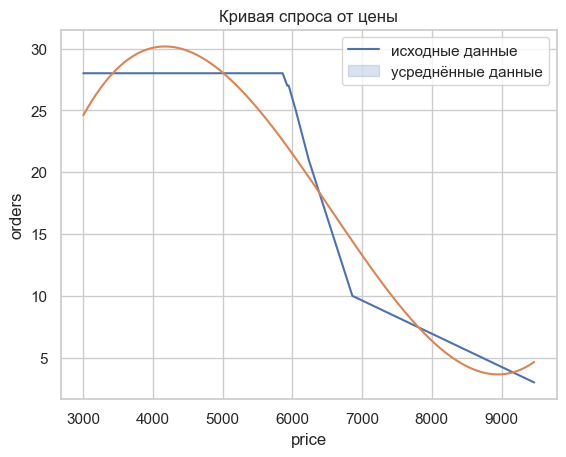

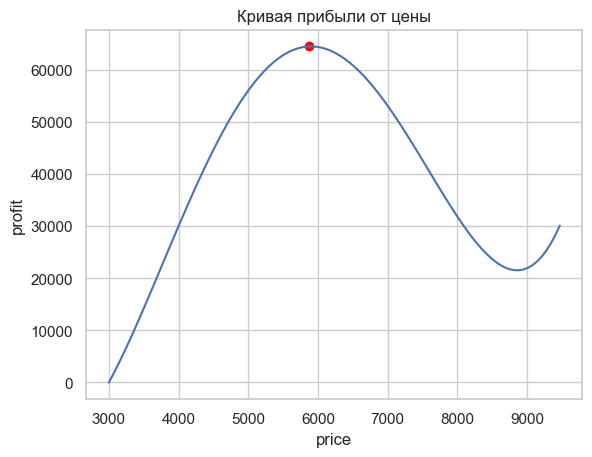


--------------------------

сегодня: 2023-04-15 
данные предыдущего периода:


date  orders    price    profit  elasticity
7  2023-04-08      27  5925.52  81043.35        True
8  2023-04-09      27  5946.57  80419.14        True
9  2023-04-10      27  5940.27  80247.31        True
10 2023-04-11      28  5859.62  80136.20        True
11 2023-04-12      28  5796.30  79380.89        True
12 2023-04-13      28  5800.87  79510.65        True
13 2023-04-14      26  5989.55  80117.81        True

считаем оптимальную цену 7 дней


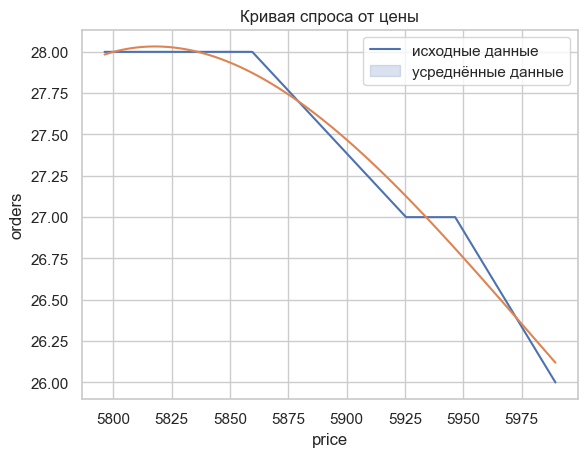

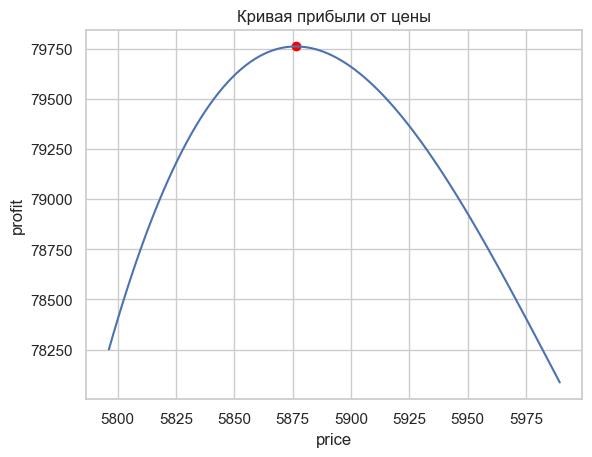

считаем оптимальную цену 14 дней


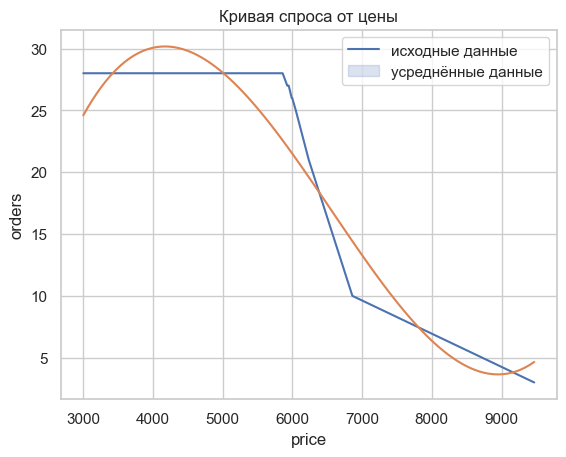

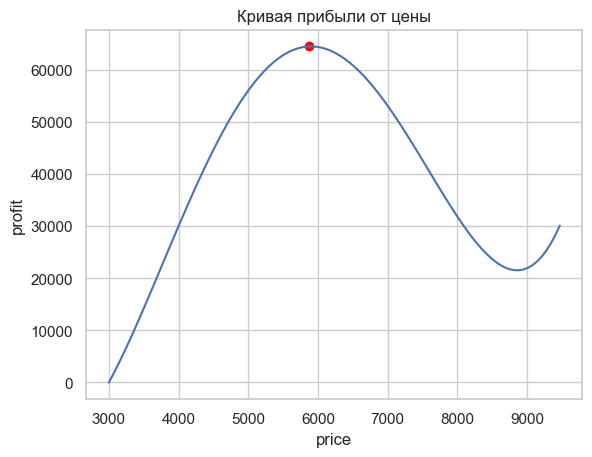


--------------------------

сегодня: 2023-04-16 
данные предыдущего периода:


date  orders    price    profit  elasticity
8  2023-04-09      27  5946.57  80419.14        True
9  2023-04-10      27  5940.27  80247.31        True
10 2023-04-11      28  5859.62  80136.20        True
11 2023-04-12      28  5796.30  79380.89        True
12 2023-04-13      28  5800.87  79510.65        True
13 2023-04-14      26  5989.55  80117.81        True
14 2023-04-15      28  5800.08  79488.03        True

считаем оптимальную цену 7 дней


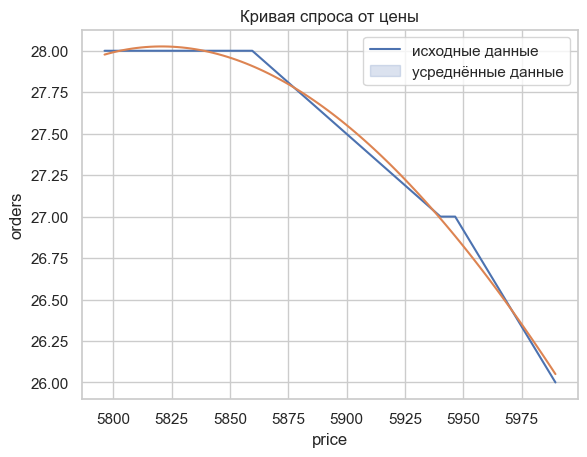

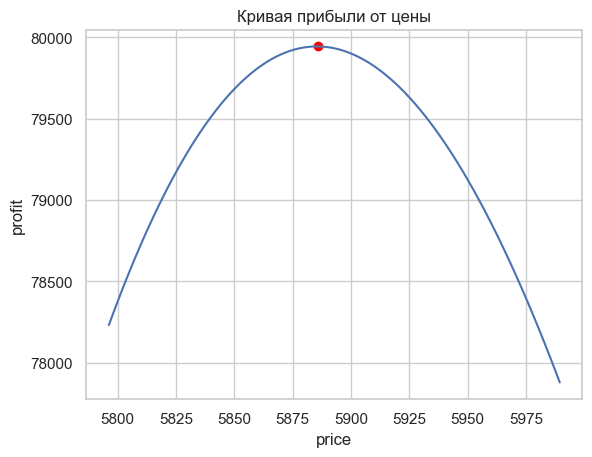

считаем оптимальную цену 14 дней


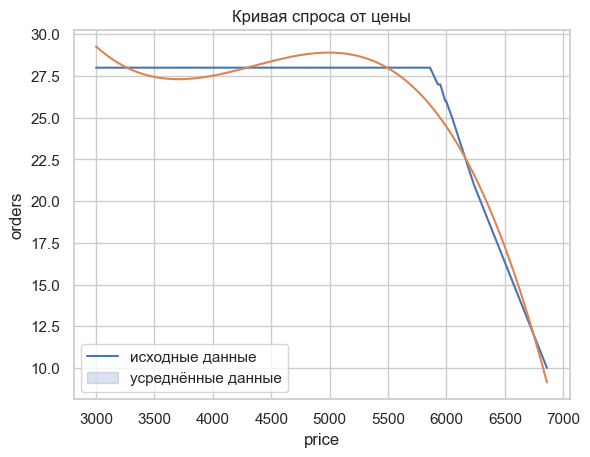

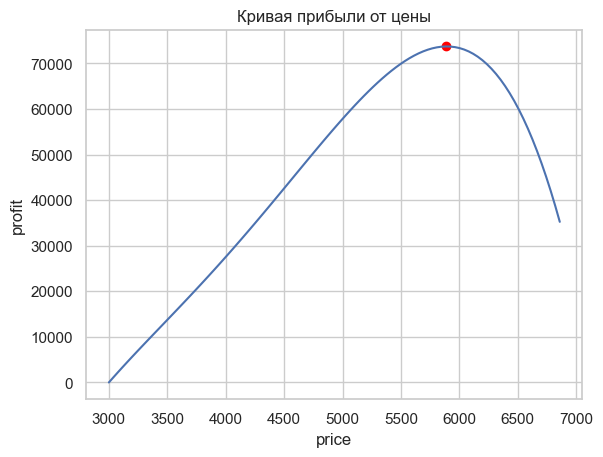


--------------------------

сегодня: 2023-04-17 
данные предыдущего периода:


date  orders    price    profit  elasticity
9  2023-04-10      27  5940.27  80247.31        True
10 2023-04-11      28  5859.62  80136.20        True
11 2023-04-12      28  5796.30  79380.89        True
12 2023-04-13      28  5800.87  79510.65        True
13 2023-04-14      26  5989.55  80117.81        True
14 2023-04-15      28  5800.08  79488.03        True
15 2023-04-16      28  5888.70  80951.28        True

считаем оптимальную цену 7 дней


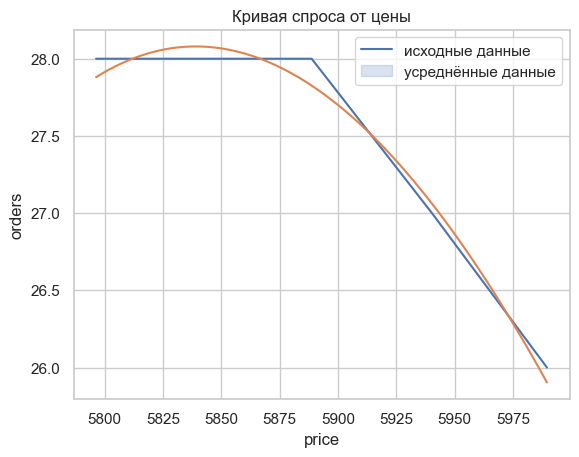

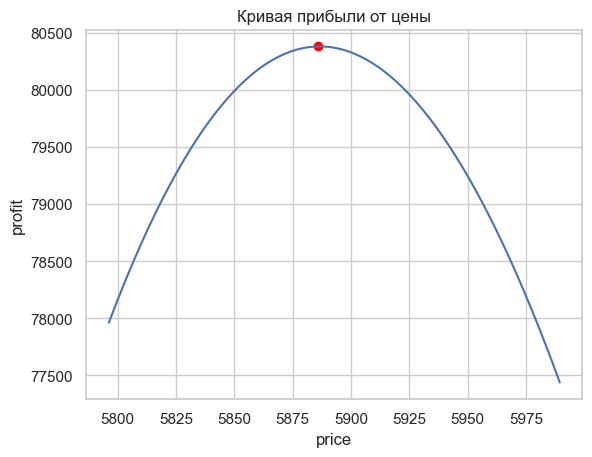

считаем оптимальную цену 14 дней


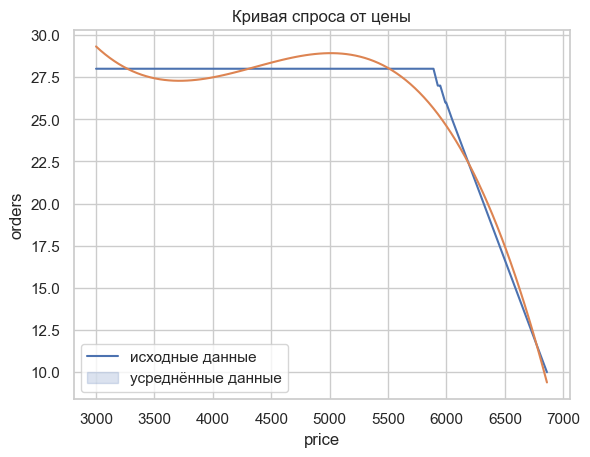

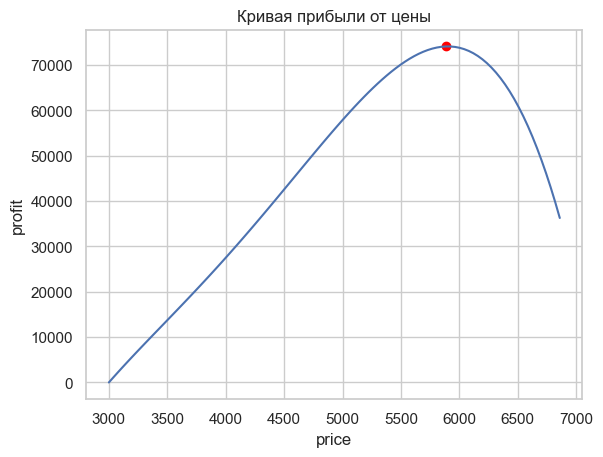


--------------------------

сегодня: 2023-04-18 
данные предыдущего периода:


date  orders    price    profit  elasticity
10 2023-04-11      28  5859.62  80136.20        True
11 2023-04-12      28  5796.30  79380.89        True
12 2023-04-13      28  5800.87  79510.65        True
13 2023-04-14      26  5989.55  80117.81        True
14 2023-04-15      28  5800.08  79488.03        True
15 2023-04-16      28  5888.70  80951.28        True
16 2023-04-17      28  5807.20  79690.07        True

считаем оптимальную цену 7 дней


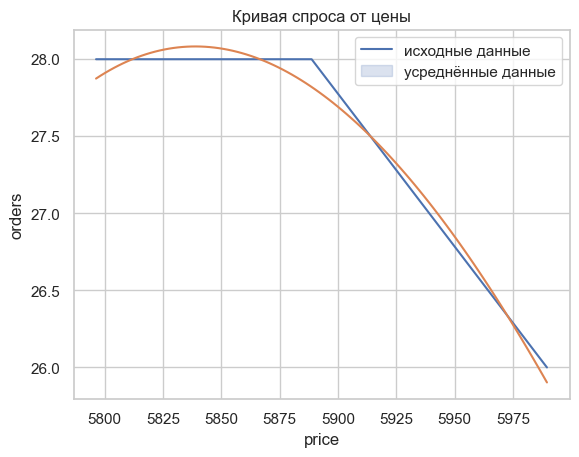

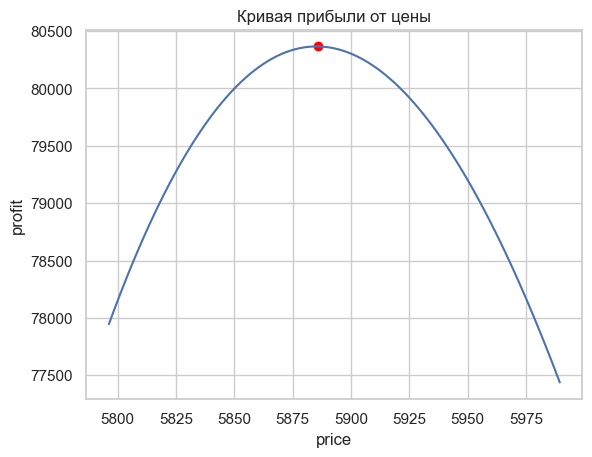

считаем оптимальную цену 14 дней


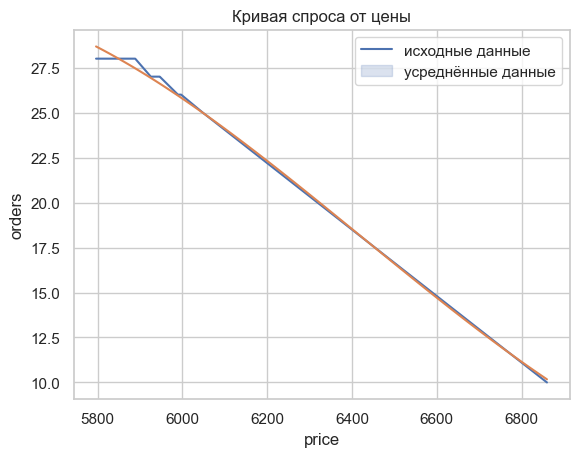

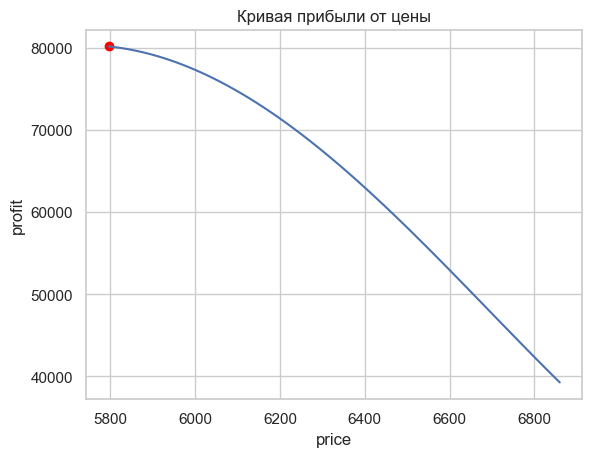


--------------------------

сегодня: 2023-04-19 
данные предыдущего периода:


date  orders    price    profit  elasticity
11 2023-04-12      28  5796.30  79380.89        True
12 2023-04-13      28  5800.87  79510.65        True
13 2023-04-14      26  5989.55  80117.81        True
14 2023-04-15      28  5800.08  79488.03        True
15 2023-04-16      28  5888.70  80951.28        True
16 2023-04-17      28  5807.20  79690.07        True
17 2023-04-18      28  5874.98  80566.79        True

считаем оптимальную цену 7 дней


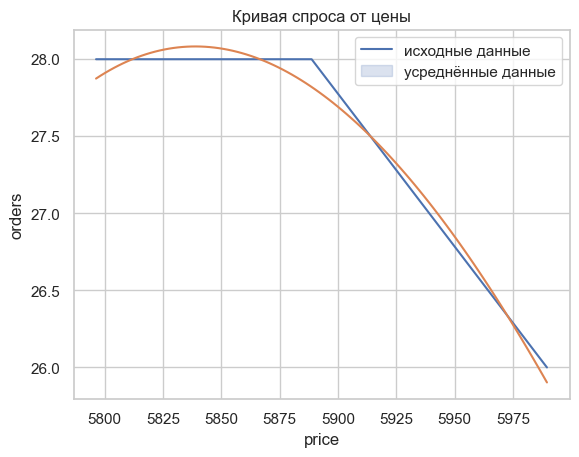

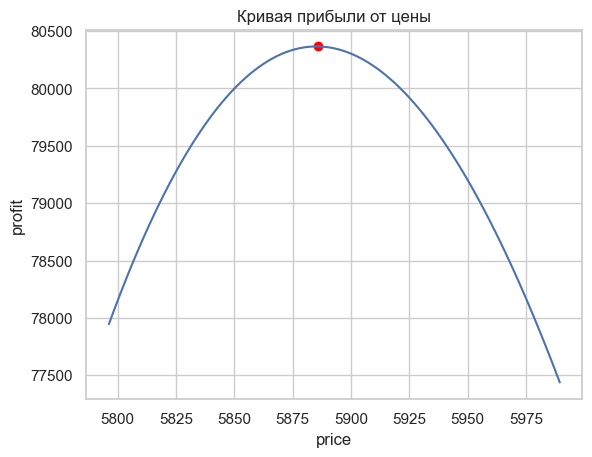

считаем оптимальную цену 14 дней


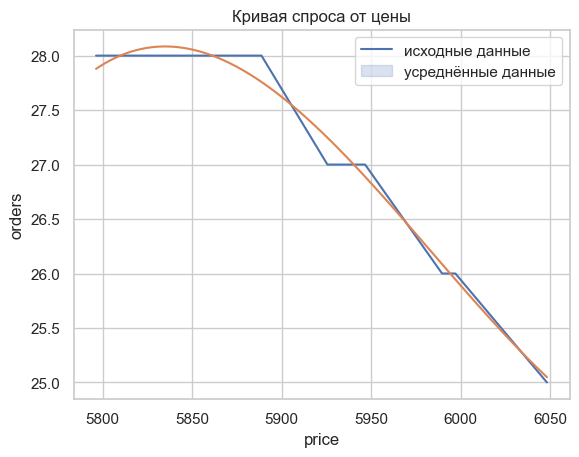

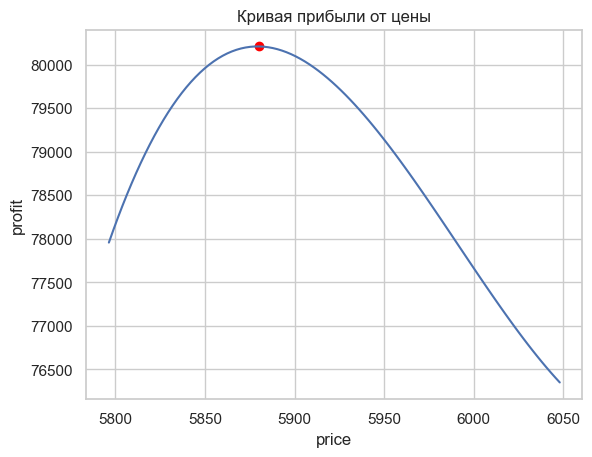


--------------------------

сегодня: 2023-04-20 
данные предыдущего периода:


date  orders    price    profit  elasticity
12 2023-04-13      28  5800.87  79510.65        True
13 2023-04-14      26  5989.55  80117.81        True
14 2023-04-15      28  5800.08  79488.03        True
15 2023-04-16      28  5888.70  80951.28        True
16 2023-04-17      28  5807.20  79690.07        True
17 2023-04-18      28  5874.98  80566.79        True
18 2023-04-19      27  5909.71  80605.54        True

считаем оптимальную цену 7 дней


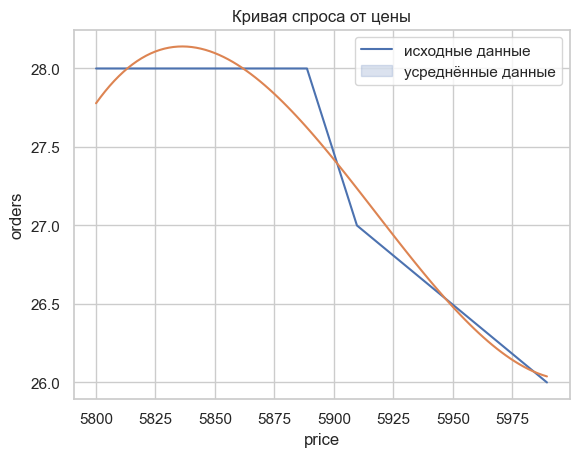

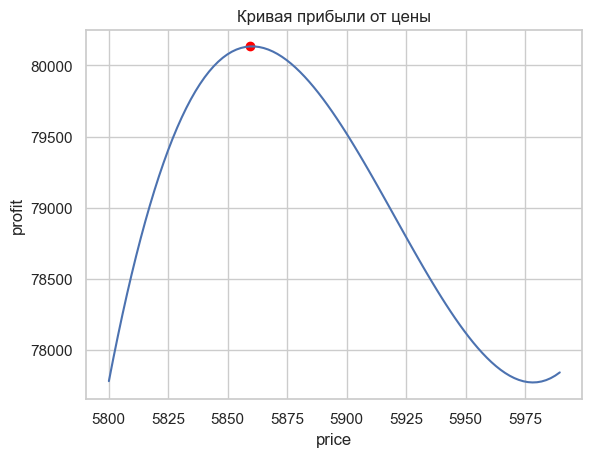

считаем оптимальную цену 14 дней


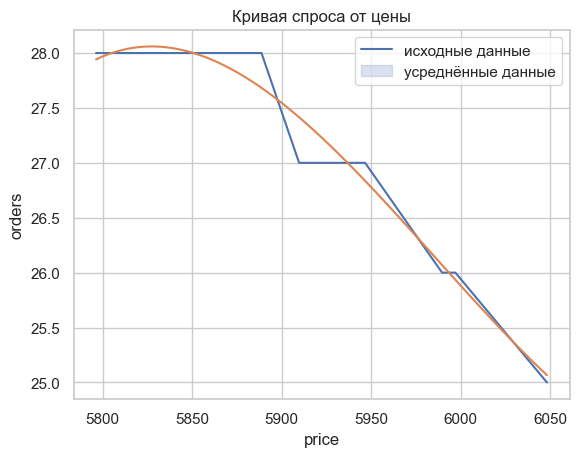

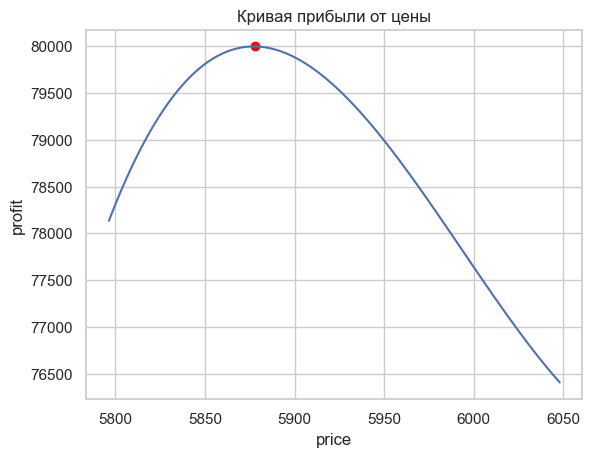


--------------------------

сегодня: 2023-04-21 
данные предыдущего периода:


date  orders    price    profit  elasticity
13 2023-04-14      26  5989.55  80117.81        True
14 2023-04-15      28  5800.08  79488.03        True
15 2023-04-16      28  5888.70  80951.28        True
16 2023-04-17      28  5807.20  79690.07        True
17 2023-04-18      28  5874.98  80566.79        True
18 2023-04-19      27  5909.71  80605.54        True
19 2023-04-20      27  5961.87  80836.75        True

считаем оптимальную цену 7 дней


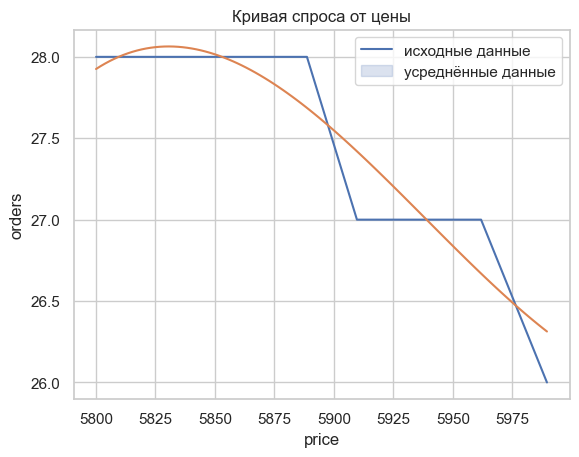

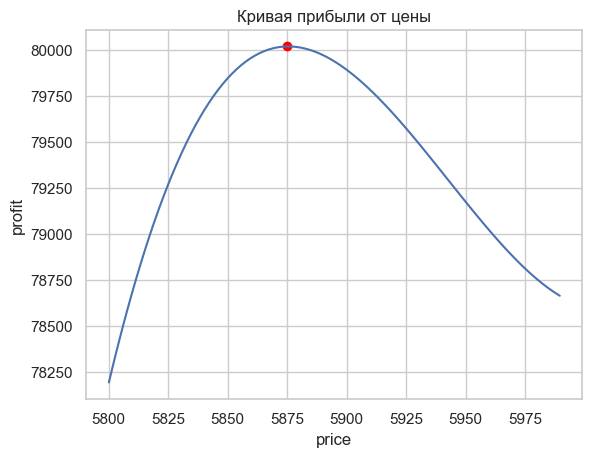

считаем оптимальную цену 14 дней


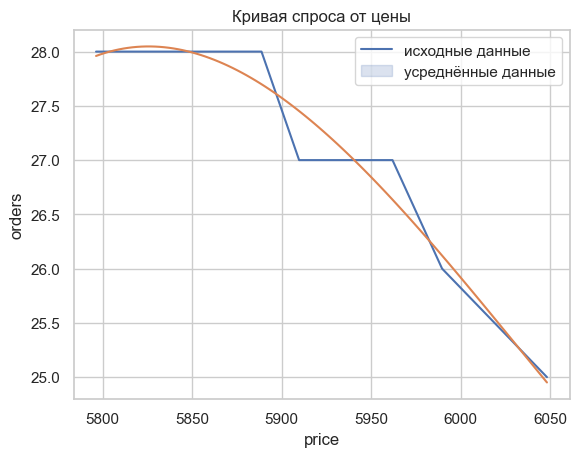

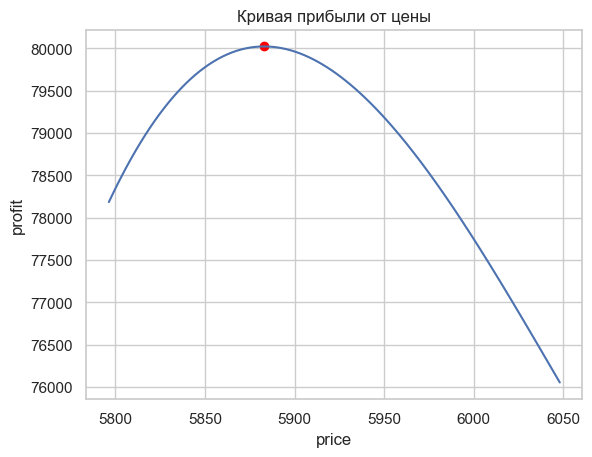


--------------------------

сегодня: 2023-04-22 
данные предыдущего периода:


date  orders    price    profit  elasticity
14 2023-04-15      28  5800.08  79488.03        True
15 2023-04-16      28  5888.70  80951.28        True
16 2023-04-17      28  5807.20  79690.07        True
17 2023-04-18      28  5874.98  80566.79        True
18 2023-04-19      27  5909.71  80605.54        True
19 2023-04-20      27  5961.87  80836.75        True
20 2023-04-21      28  5861.72  80195.14        True

считаем оптимальную цену 7 дней


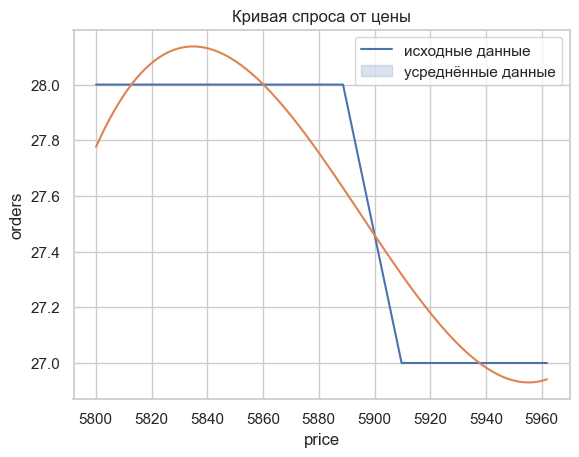

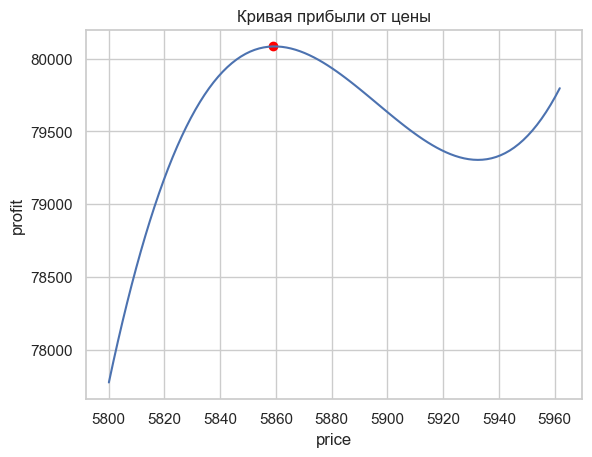

считаем оптимальную цену 14 дней


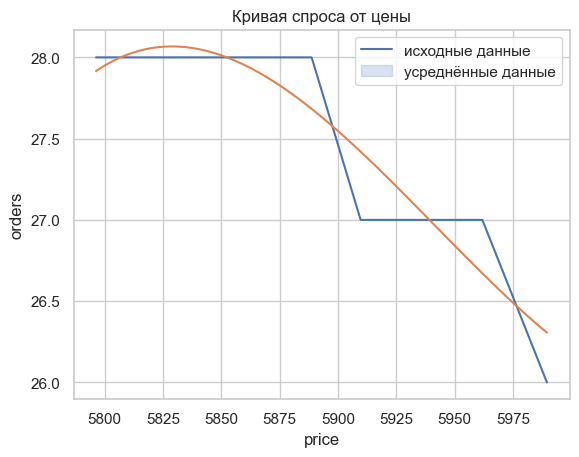

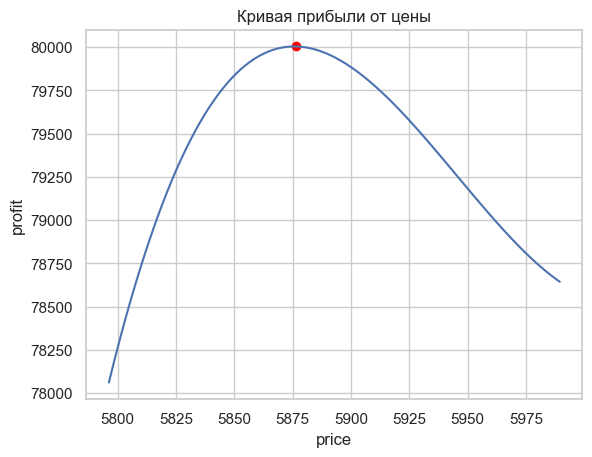


--------------------------

сегодня: 2023-04-23 
данные предыдущего периода:


date  orders    price    profit  elasticity
15 2023-04-16      28  5888.70  80951.28        True
16 2023-04-17      28  5807.20  79690.07        True
17 2023-04-18      28  5874.98  80566.79        True
18 2023-04-19      27  5909.71  80605.54        True
19 2023-04-20      27  5961.87  80836.75        True
20 2023-04-21      28  5861.72  80195.14        True
21 2023-04-22      28  5810.82  79792.95        True

считаем оптимальную цену 7 дней


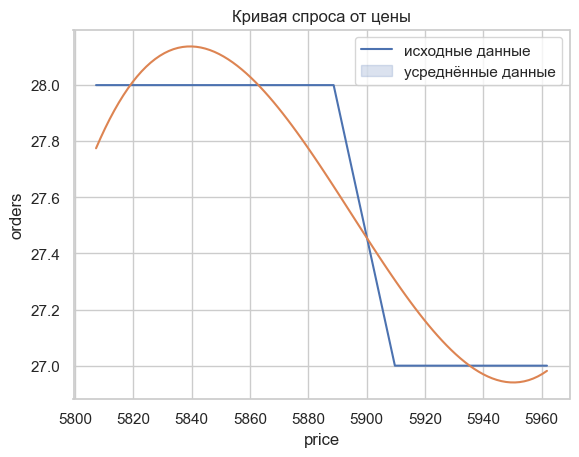

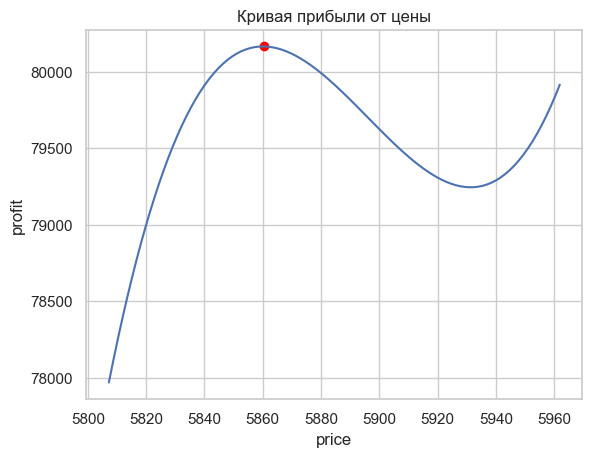

считаем оптимальную цену 14 дней


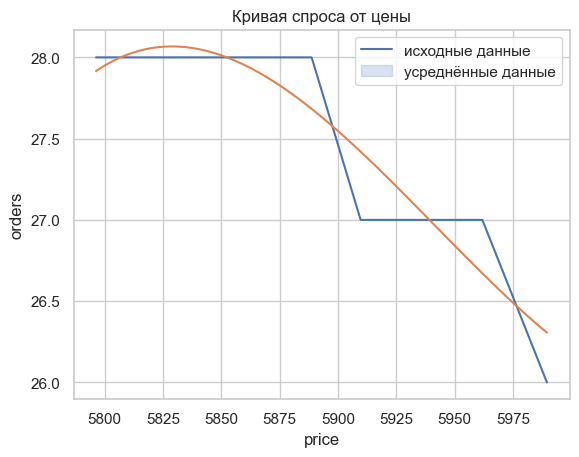

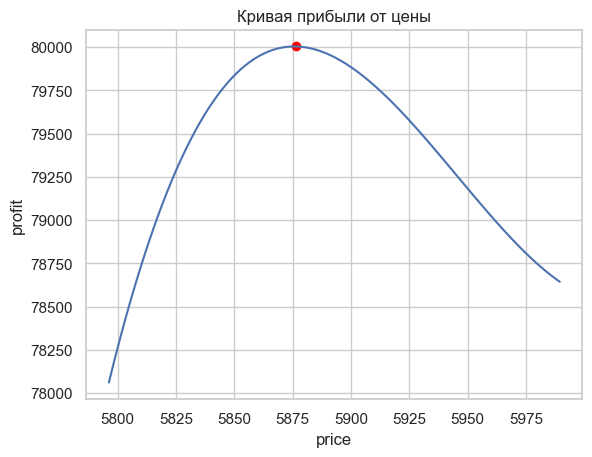


--------------------------

сегодня: 2023-04-24 
данные предыдущего периода:


date  orders    price    profit  elasticity
16 2023-04-17      28  5807.20  79690.07        True
17 2023-04-18      28  5874.98  80566.79        True
18 2023-04-19      27  5909.71  80605.54        True
19 2023-04-20      27  5961.87  80836.75        True
20 2023-04-21      28  5861.72  80195.14        True
21 2023-04-22      28  5810.82  79792.95        True
22 2023-04-23      28  5881.45  80748.14        True

считаем оптимальную цену 7 дней


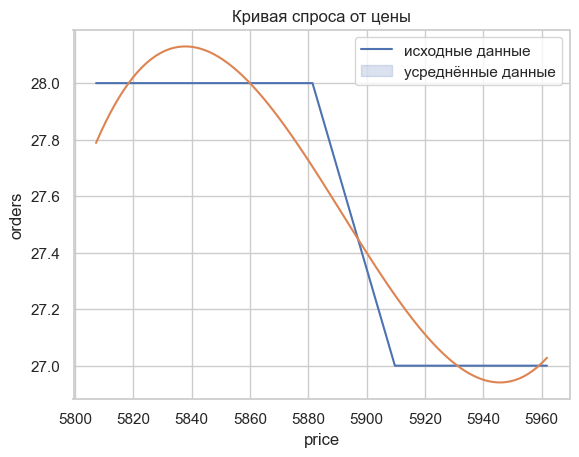

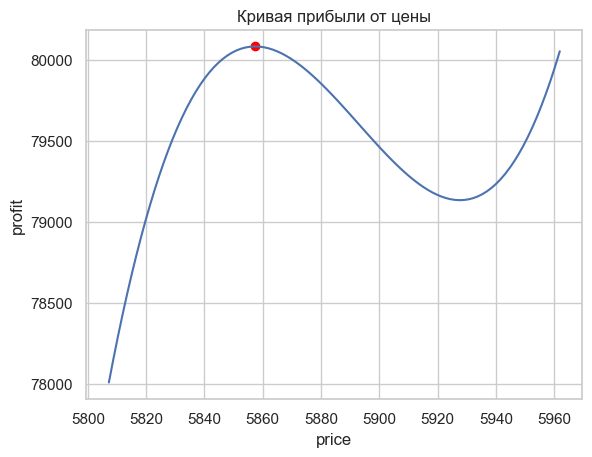

считаем оптимальную цену 14 дней


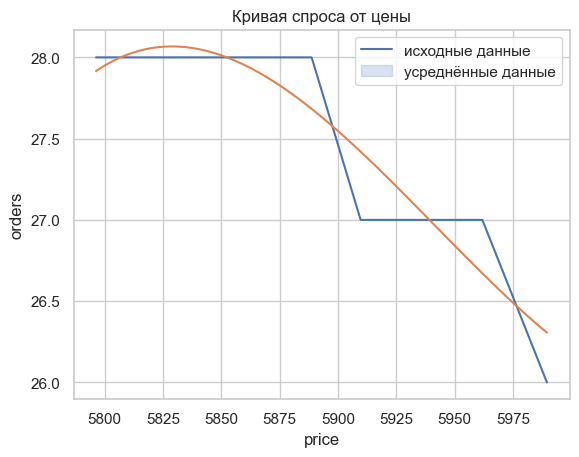

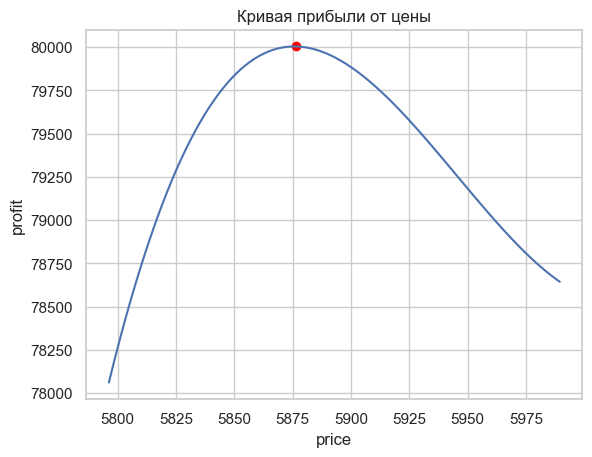


--------------------------

сегодня: 2023-04-25 
данные предыдущего периода:


date  orders    price    profit  elasticity
17 2023-04-18      28  5874.98  80566.79        True
18 2023-04-19      27  5909.71  80605.54        True
19 2023-04-20      27  5961.87  80836.75        True
20 2023-04-21      28  5861.72  80195.14        True
21 2023-04-22      28  5810.82  79792.95        True
22 2023-04-23      28  5881.45  80748.14        True
23 2023-04-24      28  5754.70  78316.49        True

считаем оптимальную цену 7 дней


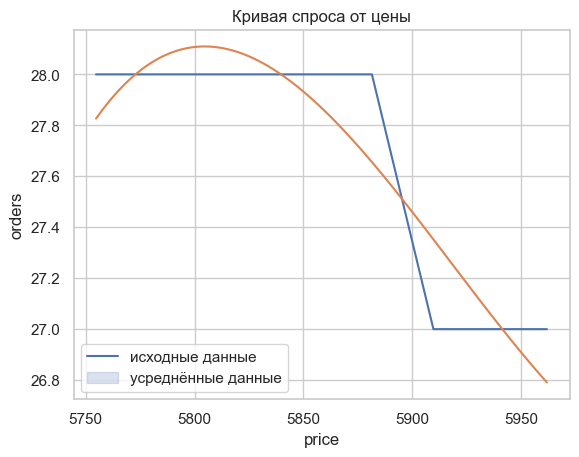

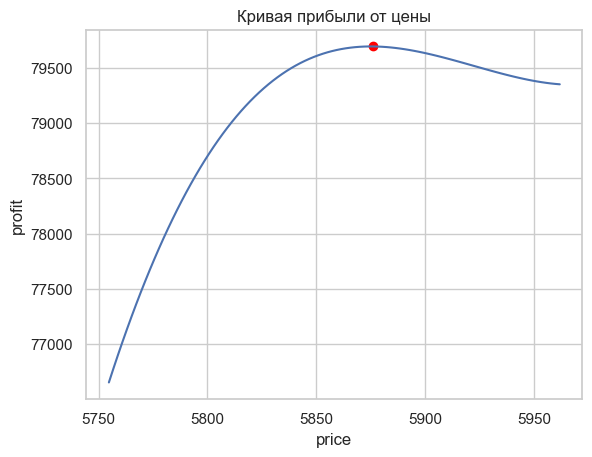

считаем оптимальную цену 14 дней


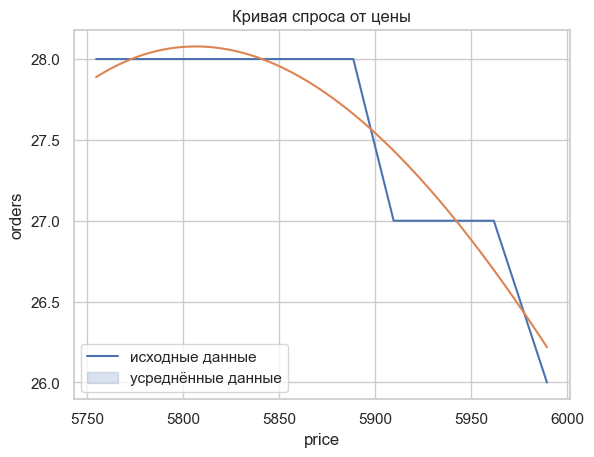

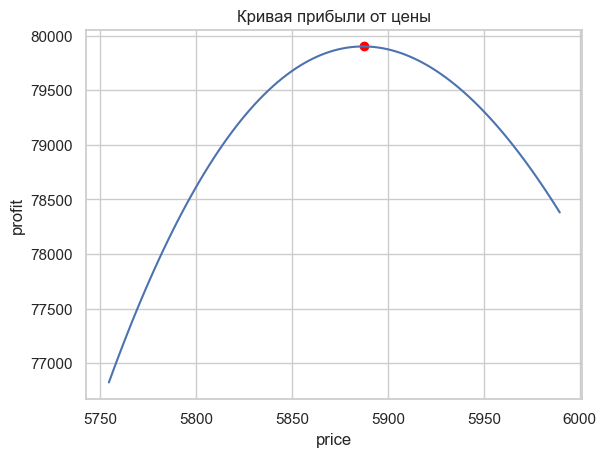


--------------------------

сегодня: 2023-04-26 
данные предыдущего периода:


date  orders    price    profit  elasticity
18 2023-04-19      27  5909.71  80605.54        True
19 2023-04-20      27  5961.87  80836.75        True
20 2023-04-21      28  5861.72  80195.14        True
21 2023-04-22      28  5810.82  79792.95        True
22 2023-04-23      28  5881.45  80748.14        True
23 2023-04-24      28  5754.70  78316.49        True
24 2023-04-25      26  5971.49  79633.65        True

считаем оптимальную цену 7 дней


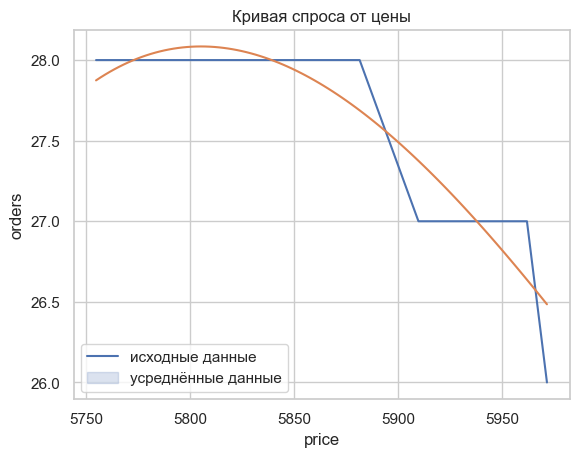

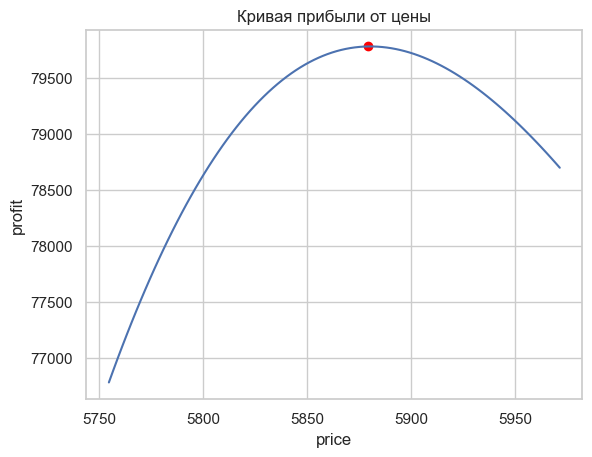

считаем оптимальную цену 14 дней


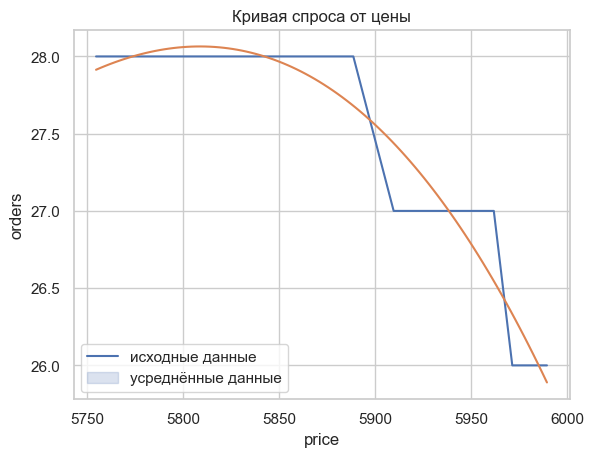

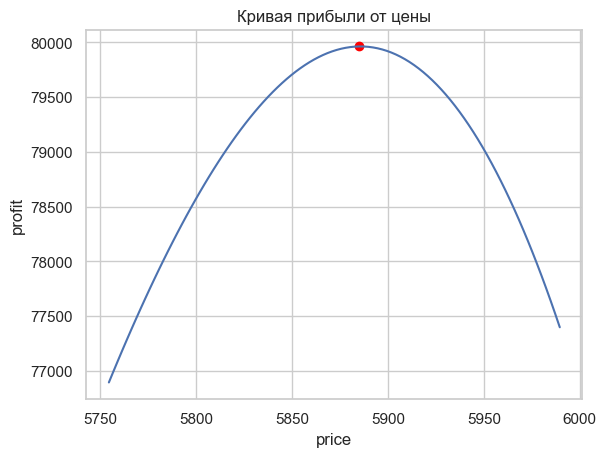


--------------------------

сегодня: 2023-04-27 
данные предыдущего периода:


date  orders    price    profit  elasticity
19 2023-04-20      27  5961.87  80836.75        True
20 2023-04-21      28  5861.72  80195.14        True
21 2023-04-22      28  5810.82  79792.95        True
22 2023-04-23      28  5881.45  80748.14        True
23 2023-04-24      28  5754.70  78316.49        True
24 2023-04-25      26  5971.49  79633.65        True
25 2023-04-26      28  5798.70  79448.98        True

считаем оптимальную цену 7 дней


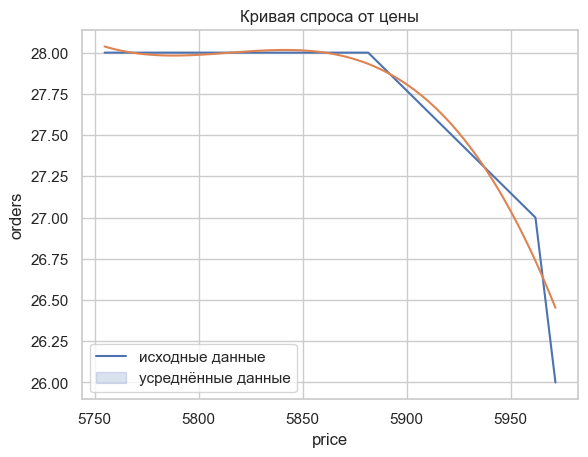

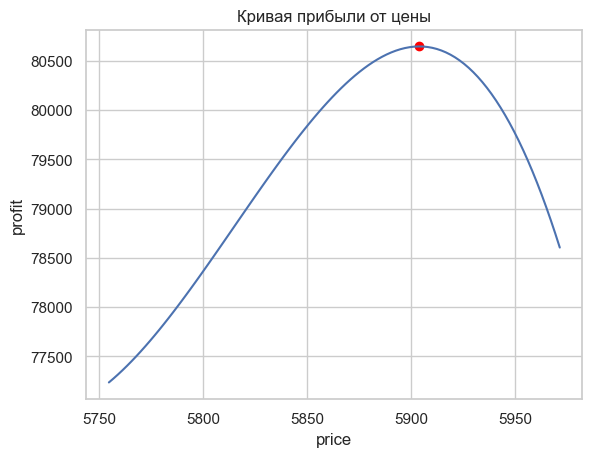

считаем оптимальную цену 14 дней


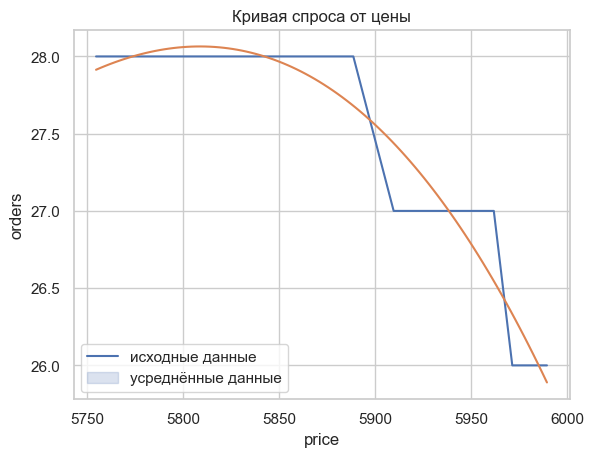

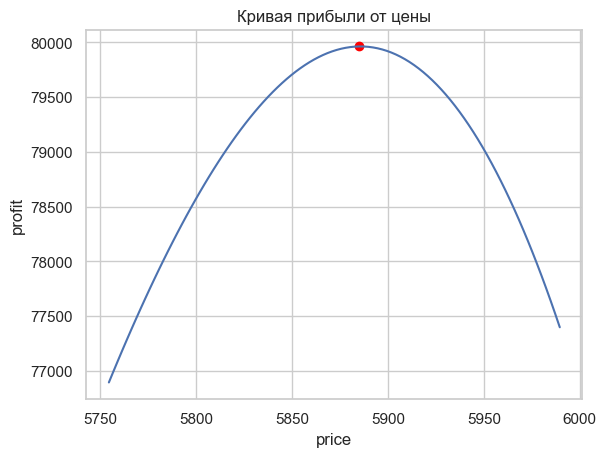


--------------------------

сегодня: 2023-04-28 
данные предыдущего периода:


date  orders    price    profit  elasticity
20 2023-04-21      28  5861.72  80195.14        True
21 2023-04-22      28  5810.82  79792.95        True
22 2023-04-23      28  5881.45  80748.14        True
23 2023-04-24      28  5754.70  78316.49        True
24 2023-04-25      26  5971.49  79633.65        True
25 2023-04-26      28  5798.70  79448.98        True
26 2023-04-27      27  5963.50  80881.34        True

считаем оптимальную цену 7 дней


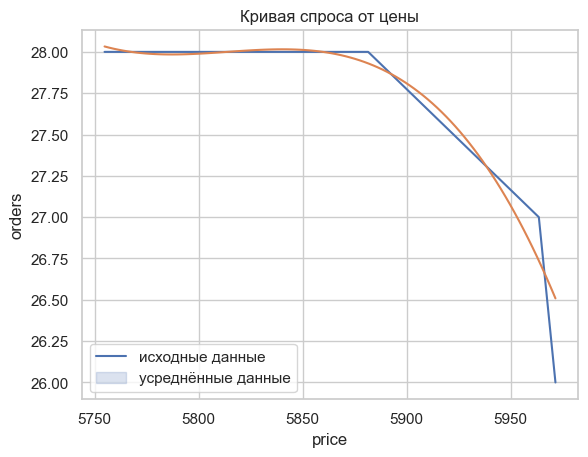

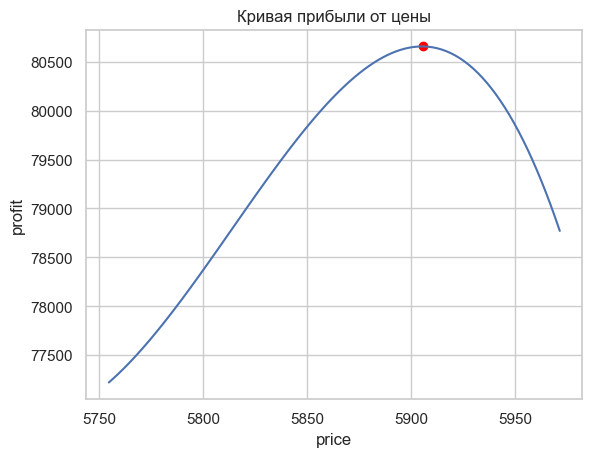

считаем оптимальную цену 14 дней


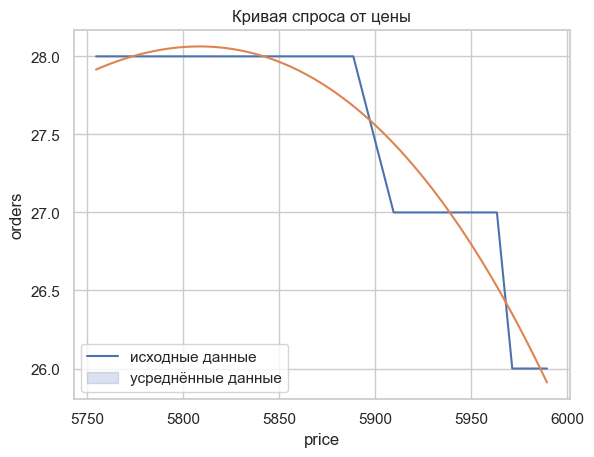

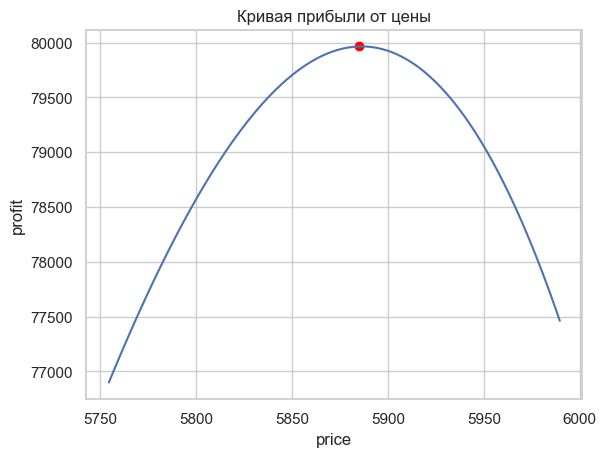


--------------------------

сегодня: 2023-04-29 
данные предыдущего периода:


date  orders    price    profit  elasticity
21 2023-04-22      28  5810.82  79792.95        True
22 2023-04-23      28  5881.45  80748.14        True
23 2023-04-24      28  5754.70  78316.49        True
24 2023-04-25      26  5971.49  79633.65        True
25 2023-04-26      28  5798.70  79448.98        True
26 2023-04-27      27  5963.50  80881.34        True
27 2023-04-28      28  5855.98  80688.38        True

считаем оптимальную цену 7 дней


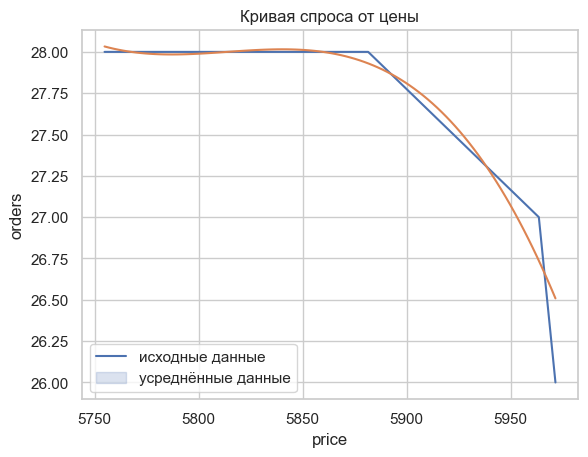

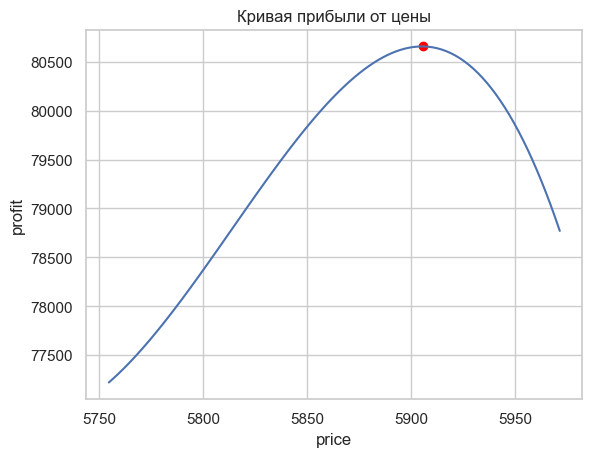

считаем оптимальную цену 14 дней


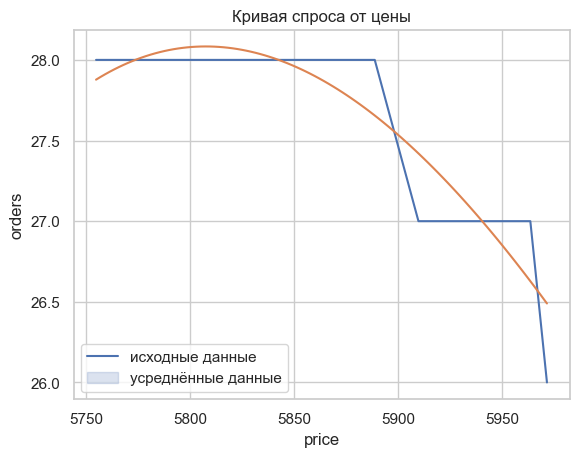

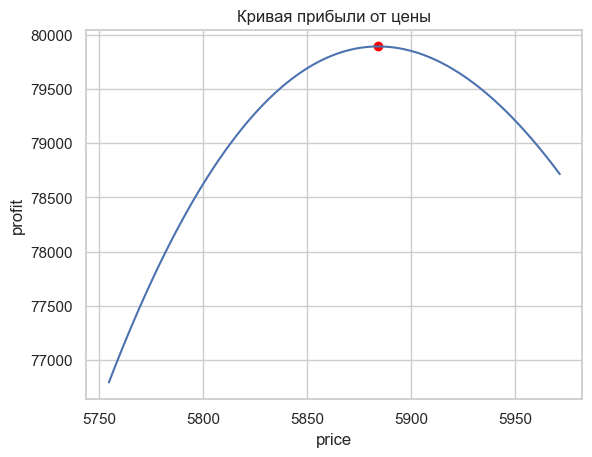


--------------------------

сегодня: 2023-04-30 
данные предыдущего периода:


date  orders    price    profit  elasticity
22 2023-04-23      28  5881.45  80748.14        True
23 2023-04-24      28  5754.70  78316.49        True
24 2023-04-25      26  5971.49  79633.65        True
25 2023-04-26      28  5798.70  79448.98        True
26 2023-04-27      27  5963.50  80881.34        True
27 2023-04-28      28  5855.98  80688.38        True
28 2023-04-29      27  5915.32  80760.98        True

считаем оптимальную цену 7 дней


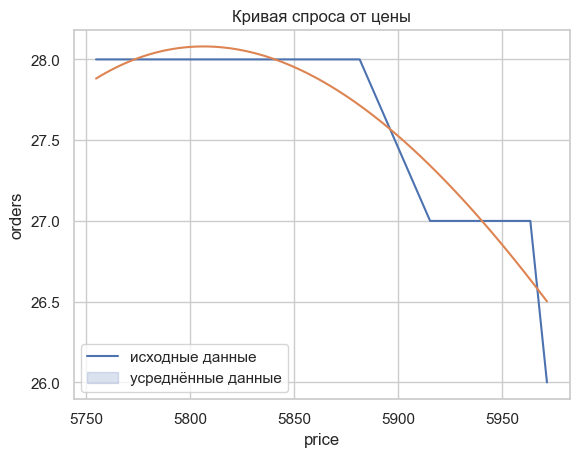

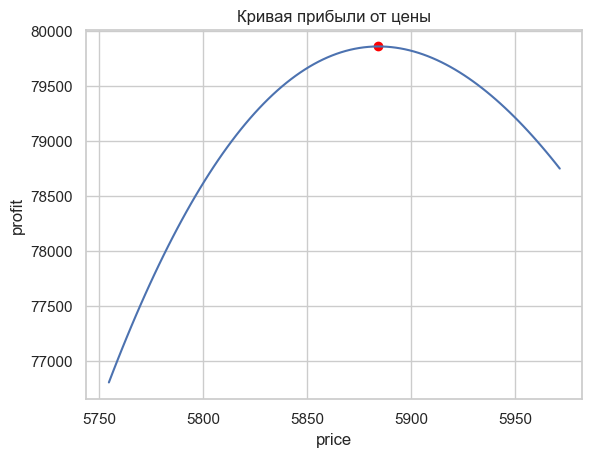

считаем оптимальную цену 14 дней


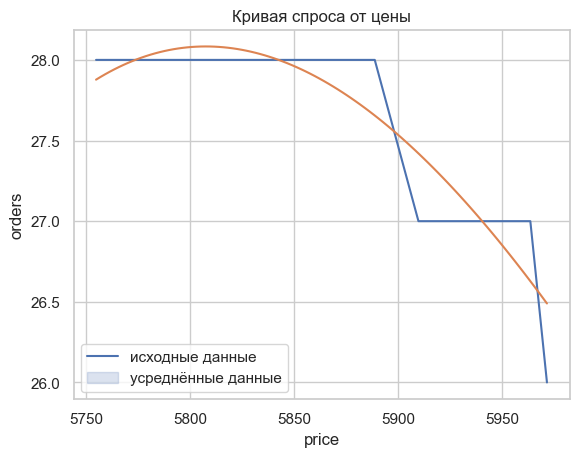

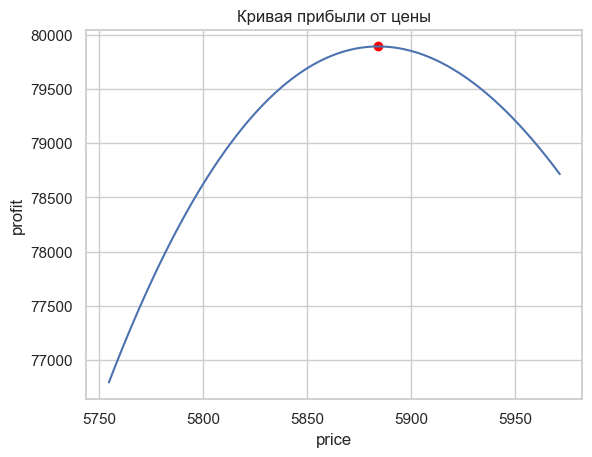


--------------------------



In [213]:
# создаём датафрейм для сбора данных
data = pd.DataFrame({'date': [], 'orders': [], 'price':[], 'profit': [], 'elasticity': []})

# запустим генерацию данных
for day in range(days):
    
    # определяем сегодняшнее число
    today = date_start + pd.Timedelta(days=day)
    print('сегодня:', today.strftime('%Y-%m-%d'), '\nданные предыдущего периода:')
    
    # получаем последние заказы за 7 и 14 дней
    last_orders_7 = get_last_orders(data, last_days=7)
    last_orders_14 = get_last_orders(data, last_days=14)
    display(last_orders_7)
    
    # выясняем можем ли мы сегодня рассчитать оптимальную цену из накопленных данных
    premission = get_premission_elasticity(last_orders_7)
    
    # получаем цену, если накопленных данных не достаточно, берём цену из списка цен для первичного тестирования эластичности
    if premission:
        print('считаем оптимальную цену 7 дней')
        price_7 = get_elast(last_orders_7[['orders', 'price']], cost_price, smoth=3, show_data=False, chart=True)[0]
        print('считаем оптимальную цену 14 дней')
        price_14 = get_elast(last_orders_14[['orders', 'price']], cost_price, smoth=3, show_data=False, chart=True)[0]
        price = (price_7 + price_14) / 2
        # чтобы мы постоянно проверяли изменение эластичности
        price = random.uniform(price*0.98, price*1.02)
    else:
        print('данных для расчёта оптимальной цены НЕ достаточно')
        primary = get_primary_price(list_prices, last_ind_list_prices)
        price = primary[0]
        
        # сохраняем индекс для последующих запросов
        last_ind_list_prices = primary[1]
        
    # получаем количество заказов сегодня исходя из цены
    orders = get_count_orders(df, price)
    
    # считаем прибыль
    profit = (price - cost_price) * orders
    
    # записываем сегодняшний результат
    data.loc[len(data.index)] = [today, int(orders), round(price, 2), round(profit, 2), premission]
    print('\n--------------------------\n')

<hr>

### Результаты
В итоге мы получили такой набор данных:

In [214]:
data

date  orders    price    profit  elasticity
0  2023-04-01       3  9468.00  24229.61       False
1  2023-04-02      21  6234.00  70038.11       False
2  2023-04-03      28  3000.00      0.00       False
3  2023-04-04      10  6860.02  39201.21        True
4  2023-04-05      27  5945.78  80397.58        True
5  2023-04-06      26  5996.99  80317.00        True
6  2023-04-07      25  6048.12  77999.96        True
7  2023-04-08      27  5925.52  81043.35        True
8  2023-04-09      27  5946.57  80419.14        True
9  2023-04-10      27  5940.27  80247.31        True
10 2023-04-11      28  5859.62  80136.20        True
11 2023-04-12      28  5796.30  79380.89        True
12 2023-04-13      28  5800.87  79510.65        True
13 2023-04-14      26  5989.55  80117.81        True
14 2023-04-15      28  5800.08  79488.03        True
15 2023-04-16      28  5888.70  80951.28        True
16 2023-04-17      28  5807.20  79690.07        True
17 2023-04-18      28  5874.98  80566.79        True
18 2023-04-19      27  5909.71  80605.54        True
19 2023-04-20      27  5961.87  80836.75        True
20 2023-04-21      28  5861.72  80195.14        True
21 2023-04-22      28  5810.82  79792.95        True
22 2023-04-23      28  5881.45  80748.14        True
23 2023-04-24      28  5754.70  78316.49        True
24 2023-04-25      26  5971.49  79633.65        True
25 2023-04-26      28  5798.70  79448.98        True
26 2023-04-27      27  5963.50  80881.34        True
27 2023-04-28      28  5855.98  80688.38        True
28 2023-04-29      27  5915.32  80760.98        True
29 2023-04-30      28  5787.43  79246.80        True

Пtрвые три строки колонки elasticity имеют значение False, это значит что мы не использовали оптимизацию подбора цены а прощупывали, набирали достаточное количество данных.  

На графиках ниже видно что этот период имеет резкие скачки изменения цены и не лучшие показатели по размеру прибыли.

Размер средней прибыли  в день 80101
Средняя цена товара 5868.2


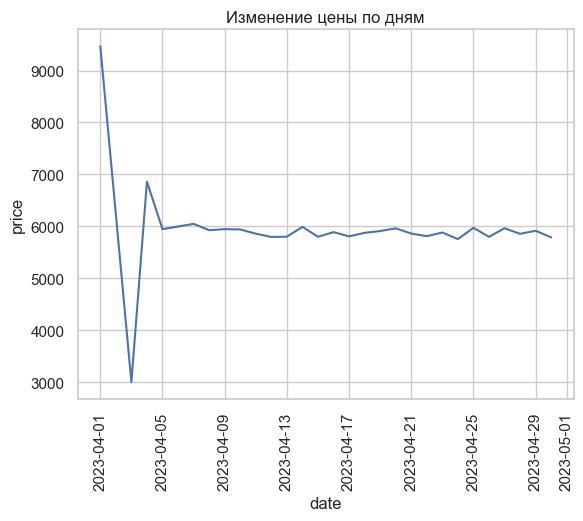

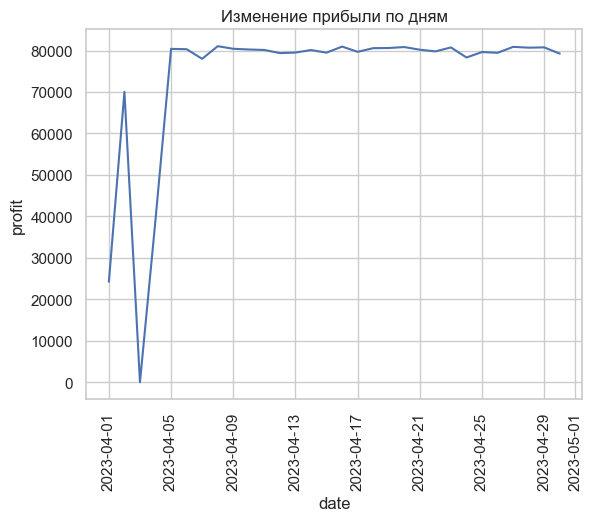

In [215]:
print('Размер средней прибыли  в день', round(data.tail(14).profit.mean()))
print('Средняя цена товара', round(data.tail(14).price.mean(), 2))

sns.lineplot(data, x='date', y='price')
plt.title('Изменение цены по дням')
plt.xticks(rotation = 90)
plt.show();

sns.lineplot(data, x='date', y='profit')
plt.title('Изменение прибыли по дням')
plt.xticks(rotation = 90)
plt.show();

Мы получили близкий к ожидаемому результат на 6 день

<hr>

### Сравнение
Сравним результаты с данными без применения определения оптимальной цены (таблица ниже).

In [216]:
bp = bp[['date', 'orders', 'revenue', 'price', 'profit']]
bp

date  orders    revenue  price     profit
0  2023-04-01      16  127872.00   7992   79872.00
1  2023-04-02      14  111888.00   7992   69888.00
2  2023-04-03       9   71928.00   7992   44928.00
3  2023-04-04       5   43956.00   8791   28956.00
4  2023-04-05       7   53586.61   7655   32586.61
5  2023-04-06       5   39960.00   7992   24960.00
6  2023-04-07       3   23676.30   7892   14676.30
7  2023-04-08       1    7892.10   7892    4892.10
8  2023-04-09       3   23676.30   7892   14676.30
9  2023-04-10      15  118381.50   7892   73381.50
10 2023-04-11      15  118381.50   7892   73381.50
11 2023-04-12      11   86813.10   7892   53813.10
12 2023-04-13      13   98701.20   7592   59701.20
13 2023-04-14       5   37462.50   7492   22462.50
14 2023-04-15      13   97402.50   7492   58402.50
15 2023-04-16      11   81318.60   7392   48318.60
16 2023-04-17      11   81318.60   7392   48318.60
17 2023-04-18       8   51144.00   6393   27144.00
18 2023-04-19      14   89502.00   6393   47502.00
19 2023-04-20      28  167832.00   5994   83832.00
20 2023-04-21      21  121678.20   5794   58678.20
21 2023-04-22      20  115884.00   5794   55884.00
22 2023-04-23      15   86913.00   5794   41913.00
23 2023-04-24      17   98501.40   5794   47501.40
24 2023-04-25      30  179820.00   5994   89820.00
25 2023-04-26      27  153746.10   5694   72746.10
26 2023-04-27      29  156443.40   5394   69443.40
27 2023-04-28      25  132367.50   5294   57367.50
28 2023-04-29      31  176523.30   5694   83523.30
29 2023-04-30      34  210589.20   6193  108589.20

Размер средней прибыли  в день 63733
Средняя цена товара 5972.21


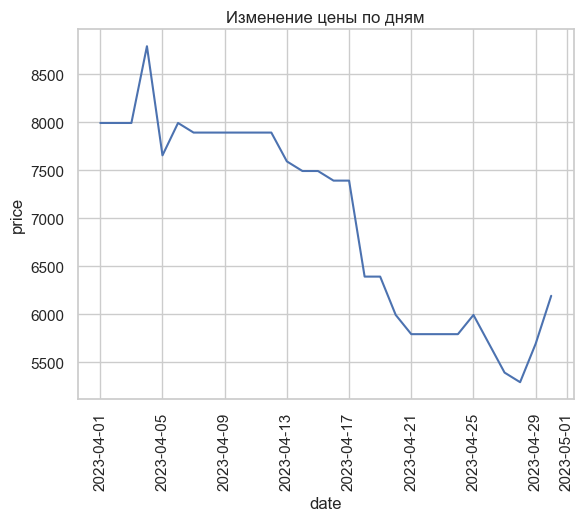

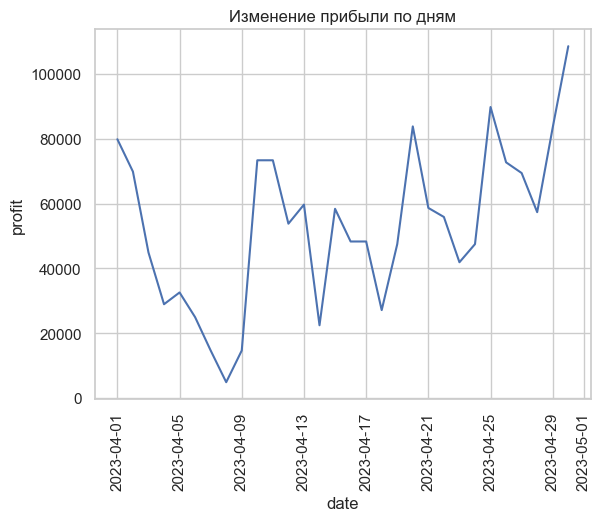

In [217]:
print('Размер средней прибыли  в день', round(bp.tail(14).profit.mean()))
print('Средняя цена товара', round(bp.tail(14).price.mean(), 2))

sns.lineplot(bp, x='date', y='price')
plt.title('Изменение цены по дням')
plt.xticks(rotation = 90)
plt.show();

sns.lineplot(bp, x='date', y='profit')
plt.title('Изменение прибыли по дням')
plt.xticks(rotation = 90)
plt.show();

Рост прибыли в этом случае более плавный, время на подбор оптимальной цены занимает значительно больше времени.

In [218]:
print('Разница в размере прибыли при использовании данных эластичности спроса в', 
      round(data.profit.sum() / bp.profit.sum(), 2), 'раза.')

Разница в размере прибыли при использовании данных эластичности спроса в 1.39 раза.


In [ ]:
С оптимизацией мы подобрали цену на 4 день